# Mini-project: Deep Learning from Scratch
### Hadeel Mhajne
### Anton Novikov


---



## **Part 1: Classifier and optimizer**

### Part 1.1

Code we deemed uninteresting or not directly related to optimization \-  we offloaded to this external python file to get it out of the way and keep this notebook clean. It also includes imports and randomness seed setting.


In [1]:
from helpers import *

### The Softmax function

We will implement softmax the way it was presented in the notes in its vectorized form:

$$P(y=p|X) = diag\left\{\sum_{j=1}^{l}exp(X^Tw_j)\right\}^{-1}exp(X^Tw_p)$$

Using the mentioned work around to compute extreme exponentials more safely:

$$P(y=p|X) = diag\left\{\sum_{j=1}^{l}exp(X^Tw_j - η)\right\}^{-1}exp(X^Tw_p - η)$$

where:

$X$ is the data matrix with datapoints $x_i$ as it's columns

$w_j$ is the weights vector matching class j

$W$ is the matrix with weights $w_j$ as it's columns

$η$ is a vector containing the max value  
 of each column of $X^Tw_j$

<br/>

**Note:** To include the bias in our computations we add the bias as a row to the weights matrix and correspondingly we add a row of ones to the data matrix \(X\).  



In [2]:
def softmax(X, W, p):
    X = add_ones_row(X)
    datapoint_size, datapoints_num = X.shape
    
    p_weight_multiplied = (X.T @ W[:, p]).reshape(-1,1)
    all_weights_multiplied = X.T @ W

    max = np.max(all_weights_multiplied, axis=1).reshape(-1, 1)
    numerator = np.exp(p_weight_multiplied - max)
    denominator = np.sum(np.exp(all_weights_multiplied - max), axis=1).reshape(-1,1)

    return numerator / denominator

### The Softmax regression loss function

$$F(\{w_k\}_{k=1} ^l) = -\frac{1} {m} \sum_{p=1}^l (c_p)^T log\left(diag\left\{\sum_{j=1}^lexp(X^Tw_j)\right\}^{-1} exp(X^Tw_p)\right)$$

In [3]:
def softmax_regression_loss(X, W, C):
    classes_count, datapoints_num = C.shape
    datapoint_size, datapoints_num = X.shape
    datapoint_size += 1
    
    log_likelihoods_list = [
        cp_t @ np.log( softmax(X, W, p).squeeze() )
        for p, cp_t in enumerate(C)
    ]

    loss = -1/datapoints_num * np.sum( log_likelihoods_list )

    return loss

### The Softmax regression gradient

$$\nabla_{w_p}F = \frac {1}{m} X \left[diag\left\{\sum_{j}exp(X^T w_j)\right\}^{-1}exp(X^T w_p) -c_p\right]$$



In [4]:
def softmax_regression_gradient_wp(X, W, C, p):
    datapoint_size, datapoints_num = X.shape
    datapoint_size += 1

    softmax_result = softmax(X, W, p)
    Cp = C.T[:, p].reshape(-1, 1)

    grad_wp = 1 / datapoints_num * add_ones_row(X) @ (softmax(X, W, p) - Cp)

    return grad_wp


def softmax_regression_gradient_wrt_w(X, W, C):
    classes_num, datapoints_num = C.shape
    datapoint_size, datapoints_num = X.shape
    datapoint_size += 1

    grad_wp_list = [
        softmax_regression_gradient_wp(X, W, C, p) for p in range(classes_num)
    ]

    grad_W = np.array(grad_wp_list).T.squeeze()

    return grad_W

### Testing Softmax gradient
Definition as seen in lecture:

Let $d$ be a random vector, shuch that $\|d\|=O(1)$ we know that
$$f(x+ϵd)= f(x)+ϵd^T \nabla f +O(ϵ^2)$$

Suppose we have the code $grad(x)$ for computing $\nabla f(x)$. Then we can compare

$$|f(x+ϵd) - f(x)| = O(ϵ)$$

Versus

$$ |f(x+ ϵd) - f(x) - ϵd^Tgrad(x)| = O(ϵ^2)$$



In [5]:
def do_gradient_test(g, grad_g, t0, title):
    epsilon = 0.1
    step_direction = randn_norm_1(t0.shape)
    g_at_t0 = g(t0)
    grad_g_at_t0 = grad_g(t0)

    steps_num = 8
    errors_order_1 = np.zeros(steps_num)
    errors_order_2 = np.zeros(steps_num)
    steps_axis = np.arange(steps_num)
    
    grad_dot_direction = np.sum(np.multiply(grad_g_at_t0, step_direction))
    
    # table title
    row_format = "{:<10}{:<30}{:<30}"
    print(row_format.format("step", "error order 1", "error order 2"))

    for step_num in steps_axis:
        step_size = epsilon * (0.5 ** step_num)
        g_at_tk = g(t0 + step_size * step_direction)

        errors_order_1[step_num] = np.abs( np.sum(g_at_tk - g_at_t0 ))
        errors_order_2[step_num] = np.abs( np.sum(g_at_tk - g_at_t0 - step_size * grad_dot_direction ))

        print(row_format.format(step_num, errors_order_1[step_num], errors_order_2[step_num]))
    print()

    plt.semilogy(steps_axis, errors_order_1, label="Zero order approximation", linestyle="-") # plot with y axis in log-scaling
    plt.semilogy(steps_axis, errors_order_2, label="First order approximation") # plot with y axis in log-scaling
    show_with_legend(title=title, x_label="steps", y_label="error")


def do_softmax_gradient_test_wrt_w(X, W, C):
    objective = lambda t: softmax_regression_loss(X, t, C)
    grad = lambda t: softmax_regression_gradient_wrt_w(X, t, C)
    
    t0 = W
    
    do_gradient_test(objective, grad, t0, title="Softmax regression gradient test w.r.t. W in semilogarithmic plot")
    

step      error order 1                 error order 2                 
0         0.04950135628715824           0.006131811037011603          
1         0.023236590410328883          0.001551817785255566          
2         0.011233009479569844          0.00039062316703318556        
3         0.0055192002173463095         9.800706107798013e-05         
4         0.002735143290361286          2.454671222712132e-05         
5         0.0013614406481745611         6.142359107478776e-06         
6         0.0006791854482881554         1.536303754614242e-06         
7         0.00033920873769055504        3.8416542378445426e-07        



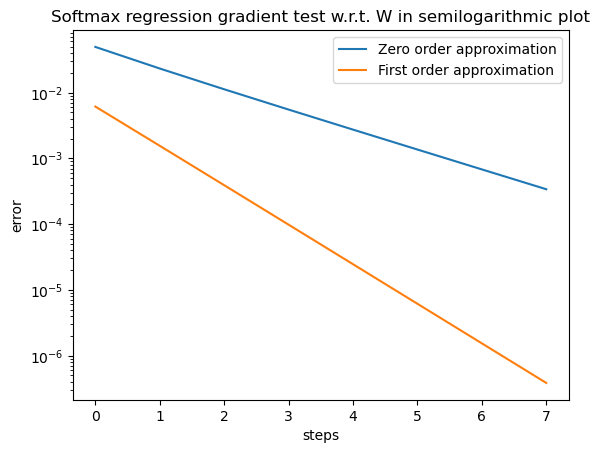

In [6]:
random_data = softmax_gradient_test_random_data()
do_softmax_gradient_test_wrt_w(*random_data)

From the difference in slopes we conclude that test is successful and the gradient implementation is correct for the loss function.

---
### Part 1.2

### SGD optimizer

We decided to implement the standard SGD optimizer with the small modification, of adding a decaying factor to the learning rate as funtion of epochs passed. In total we have 5 hyper parameters:

- number of epochs, minibatch size, learning rate
- update_factor: a decay factor used to update the learning rate
- update_rate: indicates the periodicity of updating the learning rate



In [7]:
def classify(X, W):
    raw_softmaxes = np.array([
        softmax(X, W, p)
        for p in range(W.shape[1])
    ]).squeeze()

    return raw_softmaxes


def classification_success(Y_predicted, Y_true):
    classifications = to_classes(Y_predicted)
    true_classes = to_classes(Y_true)

    return np.sum(classifications == true_classes) / classifications.shape[0]


def SGD(X_train, Y_train, X_val, Y_val, objective, objective_grad, classification=False, epochs=500, minibatch_size=64, learning_rate=1e-3, update_every=50, update_factor=0.8):
    datapoint_size, datapoints_num = X_train.shape
    classes_num, datapoints_num = Y_train.shape

    # subsample size for measuring success
    subsample_size = 0.05 # 5 percent of the datasets
    X_train_sub, Y_train_sub, _, _ = randomly_split_dataset(X_train, Y_train, split_percentage = subsample_size)
    X_val_sub, Y_val_sub, _, _ = randomly_split_dataset(X_val, Y_val, split_percentage = subsample_size)
    
    weights_shape = datapoint_size + 1, classes_num
    weights = randn_norm_1( weights_shape )
    
    train_losses, train_successes = list(), list()
    val_losses, val_successes = list(), list()
    
    if classification:
        train_success_percentages = [ classification_success(classify(X_train_sub, weights), Y_train_sub) ]
        val_success_percentages = [ classification_success(classify(X_val_sub, weights), Y_val_sub) ]
    
    for epoch_num in range(1, epochs + 1):
        minibatches = epoch_generator(X_train, Y_train, minibatch_size)
        
        if epoch_num % update_every == 0: 
            learning_rate *= update_factor
        
        for (minibatch_X, minibatch_Y) in minibatches:
            gradient = objective_grad(minibatch_X, weights, minibatch_Y)
            weights -= learning_rate * gradient
        
        train_loss = objective(X_train_sub, weights, Y_train_sub)
        val_loss = objective(X_val_sub, weights, Y_val_sub)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if classification:
            train_success = classification_success(classify(X_train_sub, weights), Y_train_sub)
            val_success = classification_success(classify(X_val_sub, weights), Y_val_sub)    
            train_successes.append(train_success)
            val_successes.append(val_success)
            
    return (weights, train_losses, train_successes, val_losses, val_successes) if classification \
        else (weights, train_losses, val_losses)

### Testing optimizer implementation using random least squares data

Defining the least squares loss:
$$F(w) = \frac{1}{2m} \left\|Xw-y\right\|^2_2$$
And the least squares gradient:
$$\nabla F(x) = \frac{1}{m}(2X^TXw − 2X^Ty)$$



In [8]:
def LS_gradient(X, weights, Y):
    datapoint_size, datapoints_num = X.shape

    X = add_ones_row(X)
    A = X.T
    b = Y.T
    
    return (1/datapoints_num * A.T) @ (A @ weights - b)


def LS_loss(X, weights, Y):
    datapoint_size, datapoints_num = X.shape

    X = add_ones_row(X)
    A = X.T
    b = Y.T

    diff = A @ weights - b
    loss = 1/(2*datapoints_num) * (diff.T @ diff).squeeze()

    return loss

Randomizing data for a least squares problem

In [9]:
X, y_noisy, true_weights = LS_random_data()
X_train, Y_train, X_val, Y_val = randomly_split_dataset(X, y_noisy, split_percentage=0.60)

Running optimizer implementation on the random LS problem

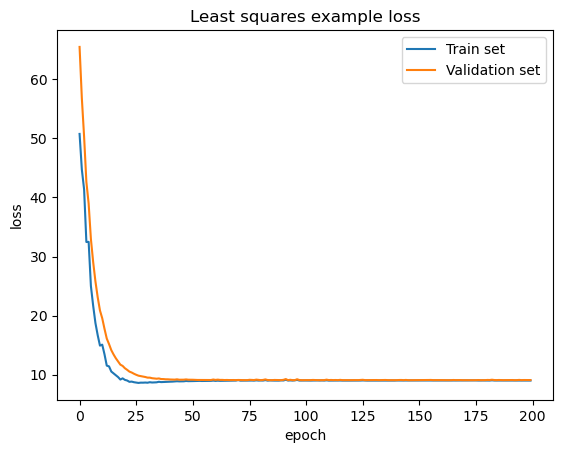

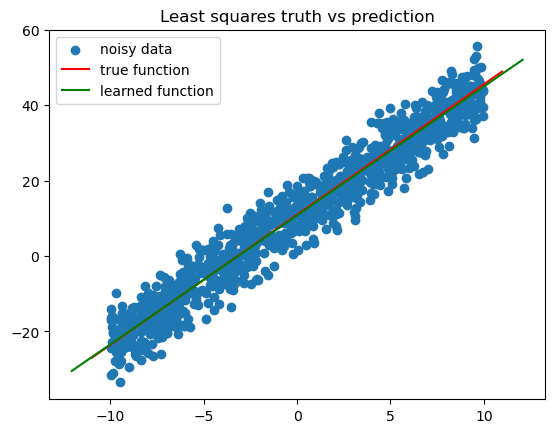

In [10]:
learned_weights, train_losses, val_losses = SGD(X_train, Y_train, X_val, Y_val, 
                                                LS_loss, LS_gradient, 
                                                epochs=200, minibatch_size=64,
                                                learning_rate=0.01)

plot_training_process(train_losses, val_losses, title="Least squares example")

plot_LS_results(X.flat, true_weights.flat, y_noisy, learned_weights.flat)

From the graphs, it's clear that the optimizer successfully found solution close-enough to the original function despite the noisy data. We conclude that the implementation of the optimizer is valid.

---
## Part 1.3

### Demonstrating minimization on the given data

We're given the following data:  

- Swissroll dataset: datapoint size = 2; classes = 2

- Peaks dataset: datapoint size = 2; classes = 5

- GMM dataset: datapoint size = 3; classes = 5

We'll use it to try to demonstrate the minimization of the softmax function using our SGD variant



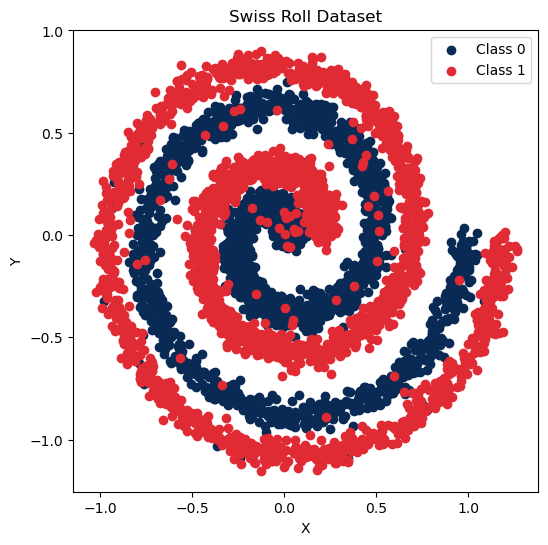

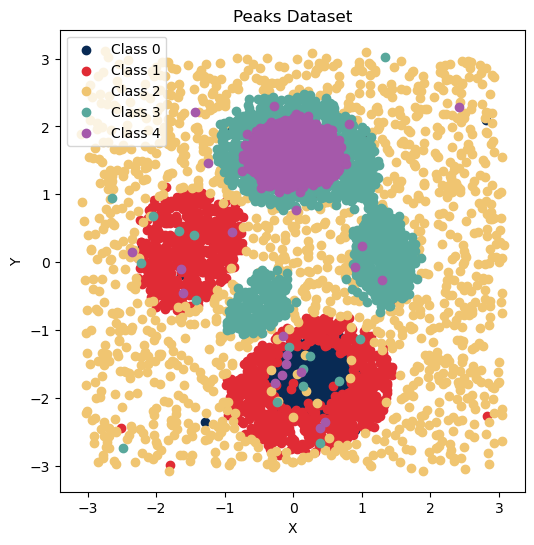

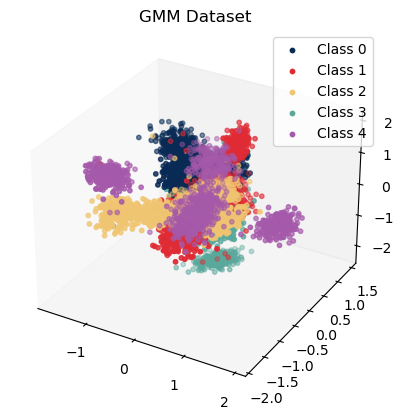

In [11]:
show_given_datasets()

#### Grid-search

##### Hyper\-parameters:

In the training process of the optimizer we tried different hyper\-parameters values:

$epochs
\in \{ 100, 300\}$ 

$minibatch\_size
\in \{ 50, 100, 300 \}$ 

$learning\_rate \in\{1e^{-n} | n = 2,...,5\}$   

$update\_rate\in\{50, 100\}$ 

$update\_factor\in \{ \frac {n}{10} | n = 8,9 \}$ 

In [12]:
epochs = [100, 300]
minibatch_sizes = [50, 100, 300]
learning_rates = [10**(-n) for n in range(2,5+1)]
update_rates = [50, 100]
update_factors = [n/10 for n in (8,9)]

datasets = {
    "SwissRoll" : load_dataset("SwissRollData.mat"),
    "Peaks" : load_dataset("PeaksData.mat"),
    "GMM" : load_dataset("GMMData.mat"),
}

combinations = tuple(product(epochs, minibatch_sizes, learning_rates, update_rates, update_factors, datasets.items()))

For the convenience of the reader we provided a backup of the trained weights and achieved results to avoid rerunnig the grid search.

In [13]:
RUN_GRID_SEARCH = False

if not RUN_GRID_SEARCH:
    grid_search_dict = load_backup("2024-04-22-15-49-12-grid_search_results.bak")

In [14]:
if RUN_GRID_SEARCH:
    GRID_SEARCH_BACKUP_FILE = f"{datetime.datetime.now():%Y-%m-%d-%H-%M-%S}-grid_search_results.bak"
    grid_search_dict = defaultdict(lambda: defaultdict(dict))

    for combination in combinations:
        ep, m_b, l_r, u_e, u_f, dataset = combination
        
        grid_search_dict[dataset[0]][ep, m_b, l_r, u_e, u_f] = SGD(
            *dataset[1], softmax_regression_loss, softmax_regression_gradient_wrt_w, 
            epochs=ep,
            minibatch_size=m_b,
            learning_rate=l_r,
            update_every=u_e,
            update_factor=u_f,
            classification=True,
        )
        
        # update backup file after every completed optimization
        save_backup(grid_search_dict, GRID_SEARCH_BACKUP_FILE)


### Examining the performance of the hyper-parameter combinations



The way we determine the best results that we got is by looking at the success percentages on the random subsample towards the end of the training process \(seems like last 10 epochs is when we should have stability in the results\).

The bigger the average success % on validation subsample, and the lower the std. error - the better we deem the result that the hyper\-parameter combination achieved.


In [15]:
last_epochs_considered = 10

processed_dict = process_grid_search_results(grid_search_dict, last_epochs_considered)

#### The best

##### The top combinations for each dataset  and their results



In [16]:
top_results_count = 4

print_grid_search_top_X(processed_dict, top_results_count)

Top 4 best performing combination of parameters:
Peaks
----------------------------------------------------------------------------------------------------------------------------------------------------------------
(epoch, minibatch, learning_rate, update_rate, update_factor)     | val. success % avg.  | val. success % std   | train success % avg  | train success % std  | 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
(300, 300, 0.001, 100, 0.8)                                       | 62.63                | 0.16                 | 54.47                | 0.02                 | 
(300, 50, 0.0001, 100, 0.9)                                       | 60.67                | 0.15                 | 58.06                | 0.03                 | 
(100, 50, 0.001, 50, 0.8)                                         | 60.26                | 0.0                  | 58.35                | 0.0

##### Loss and classification success as function of epoch for the best performing combination for each dataset

Peaks
--------------------------------------------------------------------------------


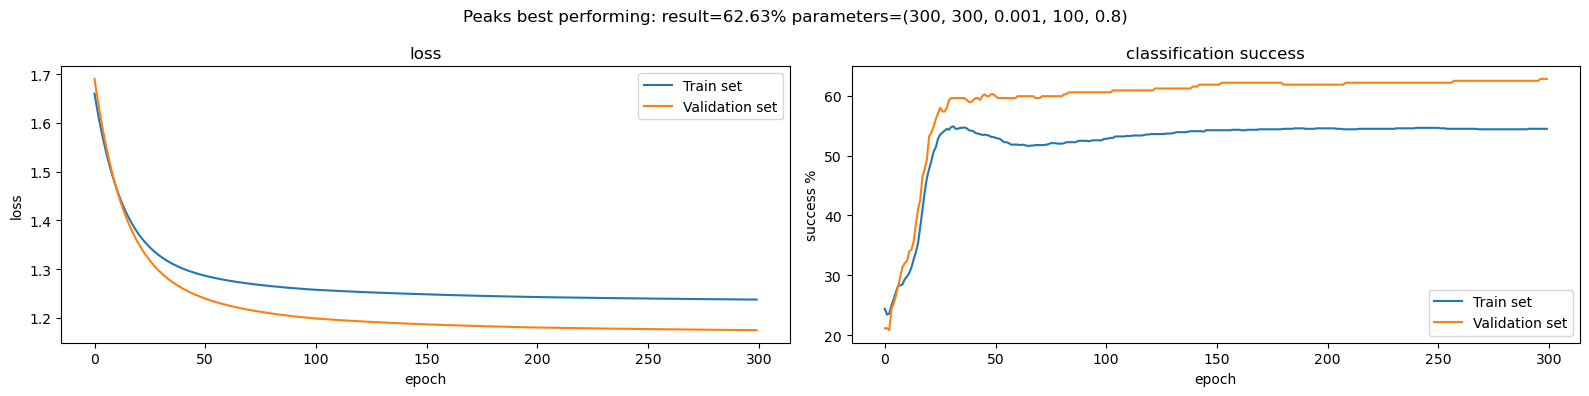

GMM
--------------------------------------------------------------------------------


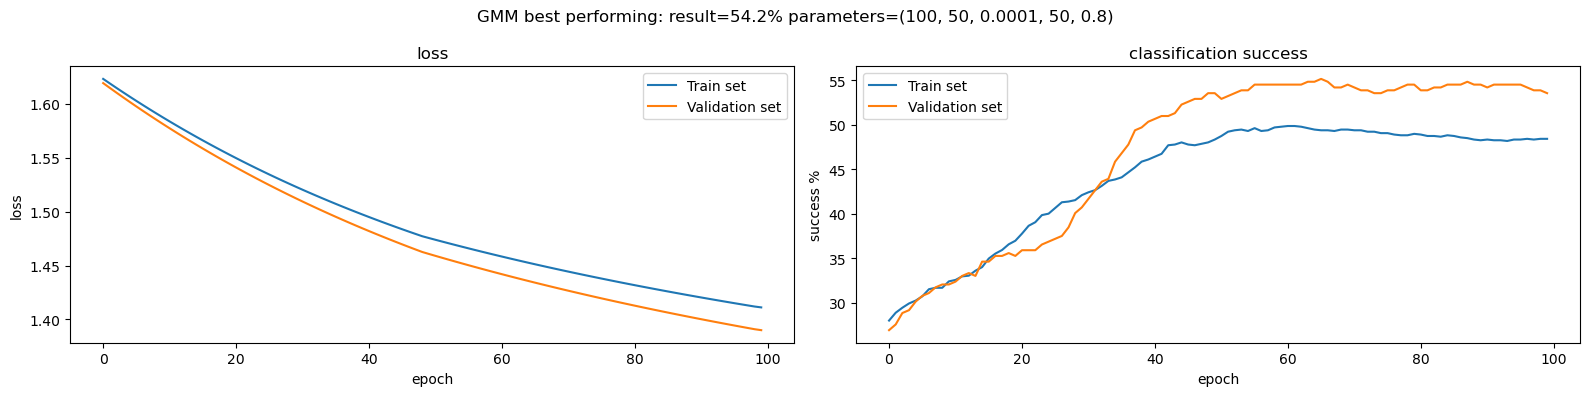

SwissRoll
--------------------------------------------------------------------------------


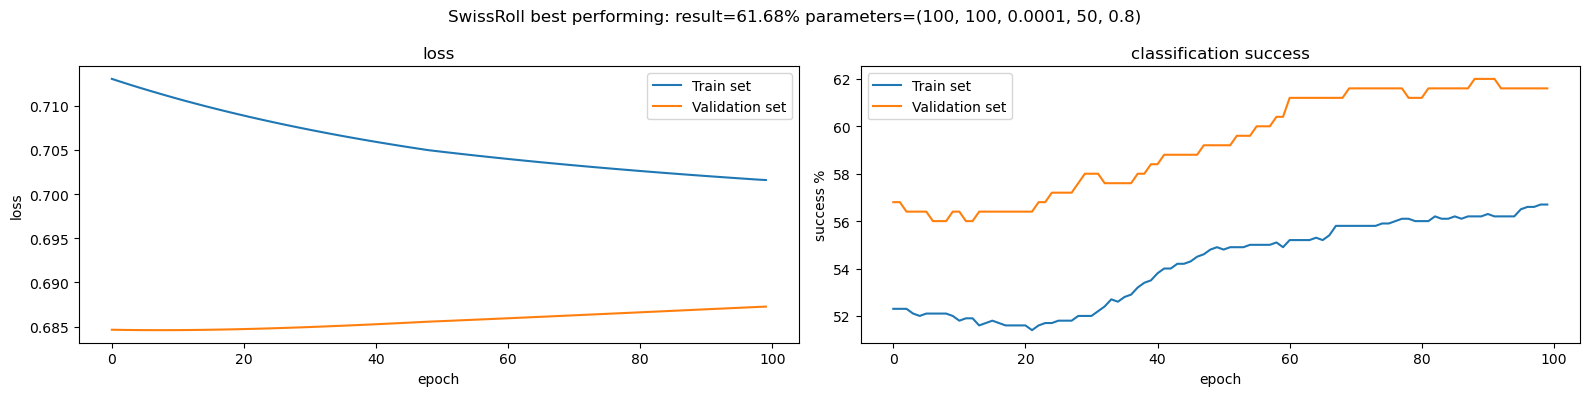

In [17]:
plot_grid_search_top(processed_dict, grid_search_dict)

#### The worst

##### Top worst combinations for each dataset 

In [18]:
print_grid_search_top_X(processed_dict, top_results_count, worst=True)

Top 4 worst performing combination of parameters:
Peaks
----------------------------------------------------------------------------------------------------------------------------------------------------------------
(epoch, minibatch, learning_rate, update_rate, update_factor)     | val. success % avg.  | val. success % std   | train success % avg  | train success % std  | 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
(100, 100, 1e-05, 100, 0.9)                                       | 7.95                 | 0.13                 | 9.17                 | 0.3                  | 
(100, 50, 1e-05, 50, 0.9)                                         | 8.27                 | 0.19                 | 9.57                 | 0.1                  | 
(300, 300, 1e-05, 50, 0.9)                                        | 10.58                | 0.0                  | 9.6                  | 0.

##### Loss and classification success as function of epoch for the worst performing combination for each dataset

Peaks
--------------------------------------------------------------------------------


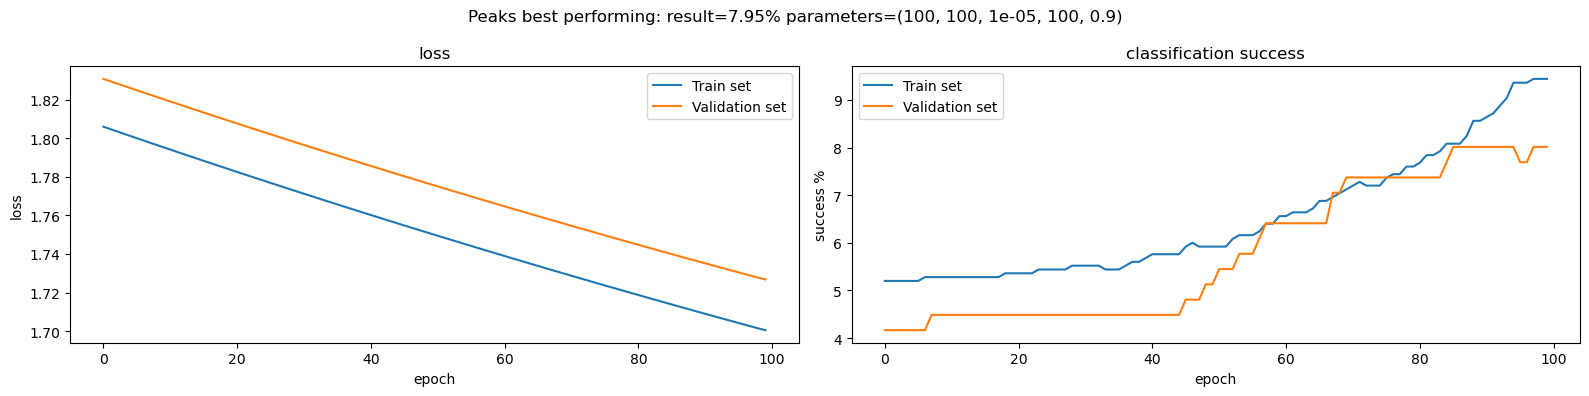

GMM
--------------------------------------------------------------------------------


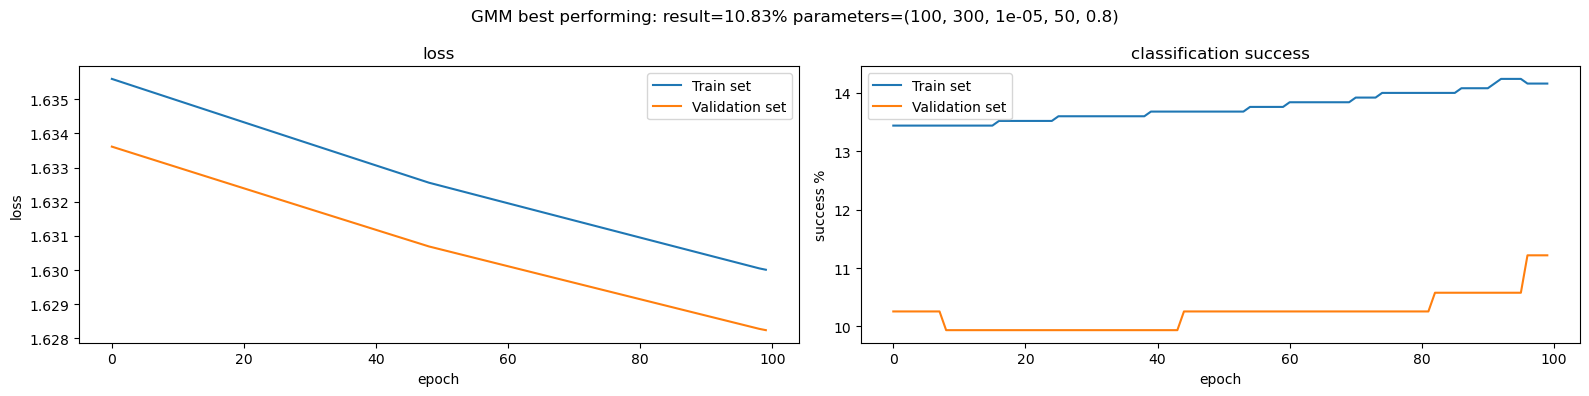

SwissRoll
--------------------------------------------------------------------------------


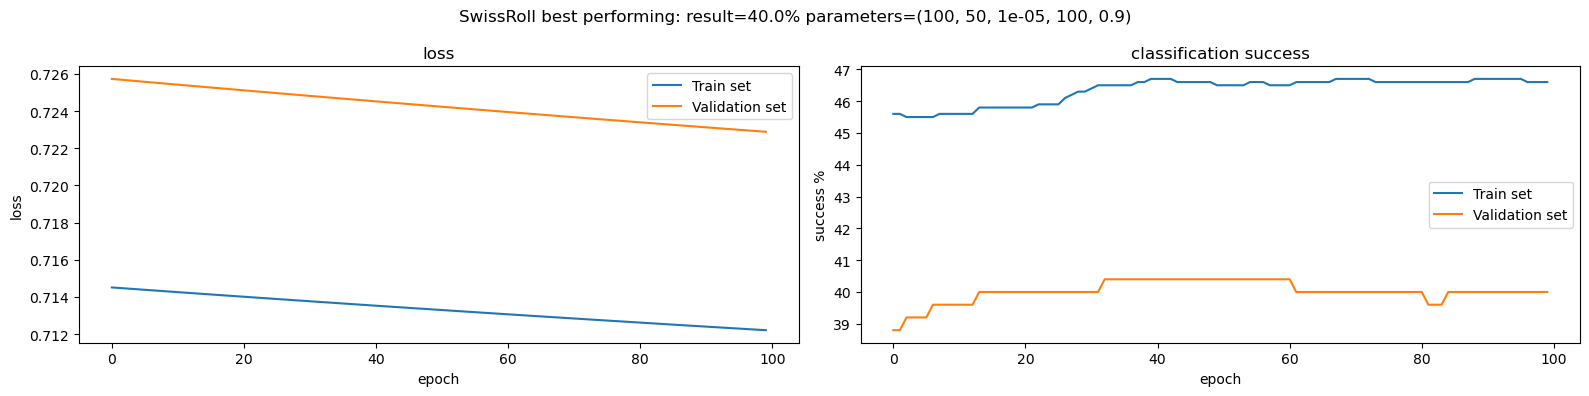

In [19]:
plot_grid_search_top(processed_dict, grid_search_dict, worst=True)

## Conclusions for Part 1

### Patterns in performance

While there doesn't seem to be an obvious pattern in the combinations that performed best, it seems like the common factor between the *worst* results is that all were achieved using using the smallest initial learning rate of $1e^{-5}$ and the smaller epochs number of $100$.

We attribute this to too slow of a progress and not enough time given to allow minimization.

### How well does the model fit to the data?

We've demonstrated that our implementation of the softmax regression is valid, using the gradient test w.r.t. the weights.

We've demonstrated that our optimizer implementation is valid using the least squares example.

Since we didn't succeed in getting high accuracy results neither on the train set nor on the validation set on any of the datasets, we conclude that softmax regression is underfit for the data.

### Did the model succeed in learning anything at all?

- Swissroll: "chance" is 50%; and best performance was around 61%.

- Peaks: "chance" is 20%; our best was around 62% 

- GMM: "chance" is 20%; our best was around 54% 

From the results it's clear that the model did learn to a certain degree, but the achieved accuracy is too low for it to be considered to model the problem space well.


### Visualizing best performing softmax models

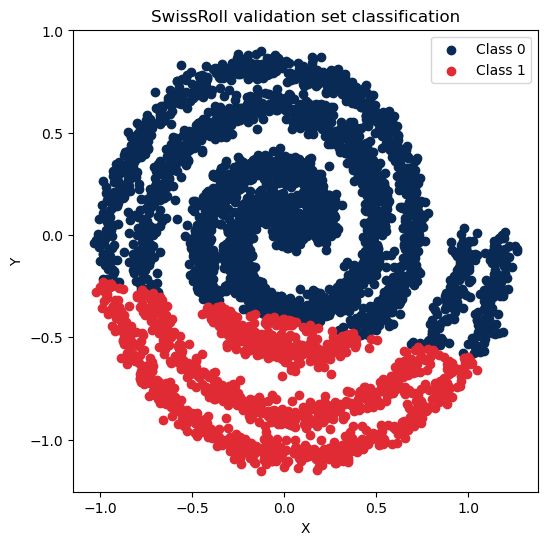

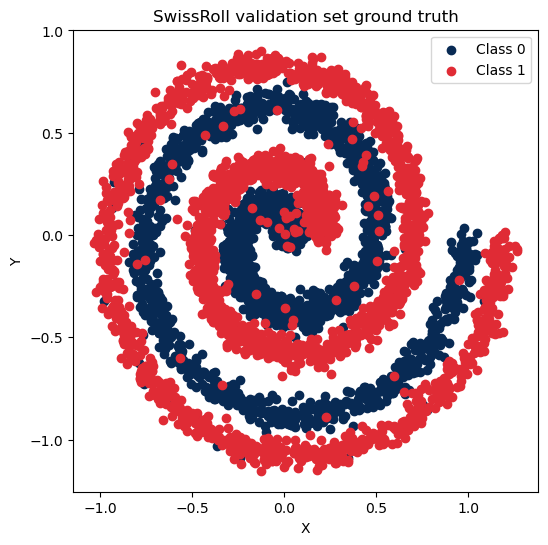

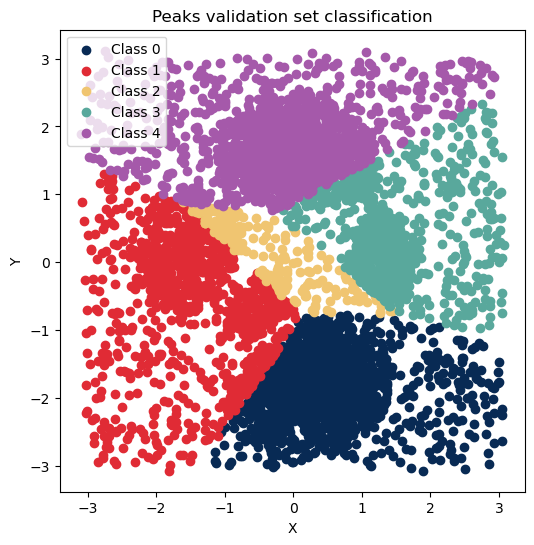

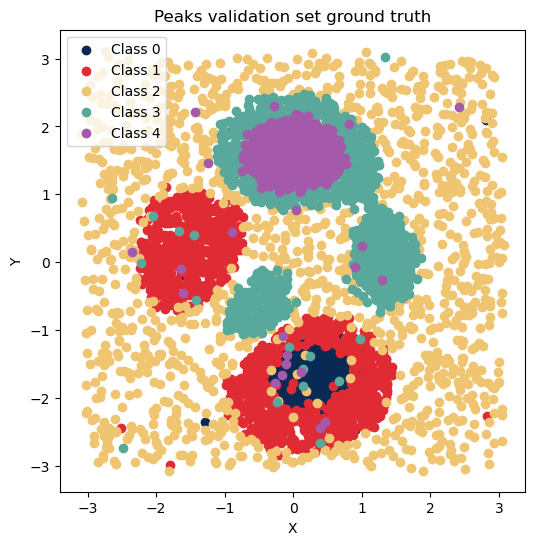

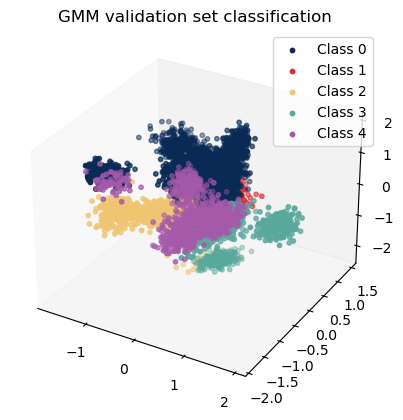

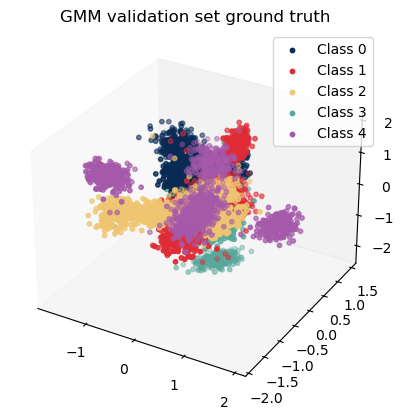

In [20]:
best_softmax_weights = get_top_grid_search_weights(processed_dict, grid_search_dict)

for (dataset_name, dataset) in datasets.items():
    _, _, X_val, Y_val = dataset

    classifications = classify(X_val, best_softmax_weights[dataset_name])

    plot_dataset(X_val, to_one_hot(to_classes(classifications), classifications.shape[0]), title=f"{dataset_name} validation set classification")
    plot_dataset(X_val, Y_val, title=f"{dataset_name} validation set ground truth")
    print()



---

---

## **Part 2: Neural network**

## Part 2.1 - Standard neural network

In this section we will implement the standard neural network's building blocks.

- Forward pass
- Backward pass

<br/>

#### Forward pass

The forward pass of the standard neural network is defined as follows:

$$
x^{(l+1)}=f(\{ W^{(l)},b^{(l)}\}, x^{(l)}) = \sigma(W^{(l)} x_i^{(l)}+b^{(l)})
$$

or in matrix-form:

$$
X^{(l+1)}=f(\{ W^{(l)},b^{(l)}\}, X^{(l)}) = \sigma(W^{(l)}X^{(l)}+b^{(l)})
$$

Where:

- $(l)$ represents the current layer
- $W^{(l)}$  is the weights' matrix of layer $l$ 
- $b^{(l)}$ is the bias of layer $l$ 
- $x^{(l)}$ is neurons of layer $l$ 
- $\sigma$ is a non\-linear function \- the activation function
- $X$ is the matix of input data-samples $x^{(l)}$ ordered as columns

**Note:** Here as well, we consider the bias computation as a column in the weights matrix.

<br/>

#### Backward pass

In order to perform optimization on the whole network, we need to compute the gradient of the network w.r.t to it's weights - the collection of weights and biases of all layers.

To that end we need to utilize the chain rule:

$$
\nabla_{\theta_L} F = \nabla_{\theta^*_L}f_L
\\
\nabla_{\theta_L} F = {\frac{\partial f_{L-1}}{\partial \theta^*_{L-1}}}^T\nabla_{X_L}f_L
\\
\vdots
\\
\nabla_{\theta_0} F = {\frac{\partial f_0}{\partial \theta^*_{0}}}^T\dots{\frac{\partial f_{L-1}}{\partial X_{L-1}}}^T\nabla_{X_L}f
$$

Where:

- $L$ represents the total number of layers
- $F$  is the network $f_L(\theta_L,\space f_{L-1}(\theta_{L-1}, \space \dots(f_0(\theta_0,\space X_0))))$
- $\theta_{l}$  is the collection  $\left\{W^{(l)}, \space b^{(l)}\right\}$

<br/>

This is performed as the computation of the "Jacobian-transposed times vector" on each layer.

for a given vector $v$, we get:

with respect to $W$:$${\frac{\partial f}{\partial W}}^Tv = (\sigma ' (WX+b) \odot v){X^T}$$ 

with respect to $X$:

$$
{\frac{\partial f}{\partial X}}^Tv = W^T(\sigma ' (WX+b)\odot v)
$$

<br/>

The last layer in our network will be the softmax regression function, so for the backpropagation we also need to define the gradient of softmax regression w.r.t. X:

$$
\nabla_X F = \frac{1}{m} W \left[ exp(W^TX) \oslash \left(\sum exp(w_j^TX) \right) - C\right]
$$

Where:

$X$ is the data matrix with datapoints $x_i$ as it's columns

$w_j$ is the weights vector matching class j

$W$ is the matrix with weights $w_j$ as it's columns

$η$ is a vector containing the max value of each column of $X^Tw_j$

$C$ is the matrix of one-hot labels of $x_i$ as it's columns

<br/>

#### Jacobian test - Abstract

To test the correctness of our implementation of the backward propagation, we implemented tests for the jacobians of the layers.

We chose to directly test the jacobian-transposed-times-vector expression. We did this by performing the previously-defined gradient test on the following scalar function:

$$
g(t)=\langle f(t),u \rangle
$$

Where:

- $f$ is a vector function (for the test we substitute it with either $f(\theta, \cdot)$ or $f(\cdot, X)$)
- $u$ is a random vector  

thus

$$
g(t+\epsilon d) = g(t) + \epsilon \langle d, J^Tu \rangle + O(\epsilon ^T \space || d||_2^2 \space ||u||_2)
$$

$$
\nabla_tg(t) = J^Tu
$$

Where $J=\frac{\partial f}{\partial t}$   

<br/>


#### Defining the data-structures that we will use to hold information of the network and perform operations


In [21]:
class Fully_connected_layer():
    def __init__(self, sample_size, new_dimention, activation, activation_deriv):
        self.input_sample_size = sample_size
        self.output_sample_size = new_dimention
        
        self.W = randn_norm_1((new_dimention, sample_size + 1))
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.last_X = np.nan
        
        
    def parameterized_forward(self, W, activation, X):
        return activation(W @ add_ones_row(X))
    
        
    def forward(self, X):
        self.last_X = X
        
        return self.parameterized_forward(self.W, self.activation, X)
    
    
    def calculate_jacobians_transposed_mult_v(self, W, X, activation, activation_deriv, v):
        sigma_prime_hadamard_v = np.multiply(activation_deriv(W @ add_ones_row(X)), v)
                                             
        layer_jacobian_wrt_weights_times_v = sigma_prime_hadamard_v @ add_ones_row(X).T
        layer_jacobian_wrt_data_times_v = W[:, :-1].T @ ( sigma_prime_hadamard_v )
        
        return layer_jacobian_wrt_weights_times_v, layer_jacobian_wrt_data_times_v

    
    def backward(self, v):
        jacobians_mult_v = self.calculate_jacobians_transposed_mult_v(self.W, self.last_X, self.activation, self.activation_deriv, v)
        
        gradient = jacobians_mult_v[0]
        passed_down_v = jacobians_mult_v[1]
        
        return gradient, passed_down_v
        
    
    def get_weights_count(self):
        return np.prod(self.W.shape)
    
    
    def update_weights(self, gradient, learning_rate):
        self.W -= learning_rate * gradient
        

    def do_direct_jacobian_transposed_test_wrt_w(self):
        # generate random data_input with expected shape
        datapoints_num = 7
        X = layer_direct_jacobian_transposed_random_data(self.W, datapoints_num)

        # define a random vector u for g function definition
        u = randn_norm_1((self.W.shape[0], X.shape[1]))
        f = lambda t: self.parameterized_forward(t, np.tanh, X)

        # g is the scalar function g(t) = dot(f(t), u)
        g = lambda t: np.vdot(f(t), u)
        # grad g(t) = Jf_t.T @ u
        grad_g = lambda t: self.calculate_jacobians_transposed_mult_v(t, X, np.tanh, tanh_deriv, u)[0]

        do_gradient_test(g, grad_g, self.W, "Direct jacobian test w.r.t W in semilogarithmic plot")
        
        
    def do_direct_jacobian_transposed_test_wrt_x(self):
        datapoints_num = 7
        X = layer_direct_jacobian_transposed_random_data(self.W, datapoints_num)

        u = randn_norm_1((self.W.shape[0], X.shape[1]))
        f = lambda t: self.parameterized_forward(self.W, np.tanh, t)
        
        g = lambda t: np.vdot(f(t), u)
        grad_g = lambda t: self.calculate_jacobians_transposed_mult_v(self.W, t, np.tanh, tanh_deriv, u)[1]

        do_gradient_test(g, grad_g, X, "Direct jacobian test w.r.t X in semilogarithmic plot")
        
        
    def do_direct_jacobian_transposed_tests(self):
        self.do_direct_jacobian_transposed_test_wrt_x()
        self.do_direct_jacobian_transposed_test_wrt_w()
    

In [22]:
class Softmax_regression_layer():
    def __init__(self, datapoint_size, classes_num):
        self.W = randn_norm_1((datapoint_size + 1, classes_num))
        self.last_X = np.nan
        self.last_C = np.nan
        
    
    def get_weights_count(self):
        return np.prod(self.W.shape)
    
    
    def update_weights(self, gradients, learning_rate):
        self.W -= learning_rate * gradients
    
    
    def calc_loss(self, X, C):
        self.last_X, self.last_C = X, C
        
        return softmax_regression_loss(X, self.W, C)
    
    
    def calc_gradients(self):
        return softmax_regression_gradient_wrt_w(self.last_X, self.W, self.last_C), self.calc_gradient_wrt_x(self.last_X, self.last_C)
    
    
    def classify(self, X):
        return classify(X, self.W)

    
    def calc_gradient_wrt_x(self, X, C):
        datapoint_size, datapoints_num = X.shape
        W = self.W
        
        all_weights_multiplied = W.T @ add_ones_row(X)
        max = np.max(all_weights_multiplied, axis=0)

        numerator = np.exp(all_weights_multiplied - max)
        denominator = np.sum(np.exp(all_weights_multiplied - max), axis=0)

        return (1 / datapoints_num) * W[:-1, :] @ (numerator / denominator - C)
        

    def do_gradient_test_wrt_x(self, X, C):
        t0 = X
        g = lambda t: softmax_regression_loss(t, self.W, C)
        grad_g = lambda t: self.calc_gradient_wrt_x(t, C)

        do_gradient_test(
            g, grad_g, t0,
            "Softmax regression gradient test w.r.t X in semilogarithmic plot"
        )
    

    def do_gradient_tests(self):
        X, _, C = softmax_gradient_test_random_data(
            datapoint_size=self.W.shape[0] - 1, 
            datapoints_num=7,
            classes_num=self.W.shape[1]
        )

        self.do_gradient_test_wrt_x(X, C)
        do_softmax_gradient_test_wrt_w(X, self.W, C)

In [23]:
class ClassificationNetwork():
    def __init__(self, layers, classes_num):
        self.hidden_layers = layers
        self.classes_num = classes_num
        self.classification_layer = Softmax_regression_layer(layers[-1].output_sample_size, classes_num)
     
    
    def forward_pass(self, X, C):
        for layer in self.hidden_layers:
            X = layer.forward(X)
        
        loss = self.classification_layer.calc_loss(X, C)
        classifications = self.classification_layer.classify(X)
        
        return classifications, loss, classification_success(classifications, C)
    
    
    def backward_pass(self, learning_rate=None, train=True):
        gradients_wrt_w = list()
        
        grad_wrt_w, v = self.classification_layer.calc_gradients()
        gradients_wrt_w.insert(0, grad_wrt_w)
        
        for layer in reversed(self.hidden_layers):
            Jw_mult_v, Jx_mult_v = layer.backward(v)
            
            gradients_wrt_w.insert(0, Jw_mult_v)
            v = Jx_mult_v
        
        if train is True:
            self.update_weights(gradients_wrt_w, learning_rate)
            
        return gradients_wrt_w
    
    
    def get_weights_count(self):
        return self.classification_layer.get_weights_count() + \
            sum(layer.get_weights_count() for layer in self.hidden_layers)
    
    
    def update_weights(self, changes, step_size):
        for (layer_index, layer) in enumerate(self.hidden_layers):
            layer.update_weights(changes[layer_index], step_size)
            
        self.classification_layer.update_weights(changes[-1], step_size)
    
    
    def do_per_layer_tests(self):
        for (layer_index, layer) in enumerate(self.hidden_layers):
            print("=" * 30)
            print(f"jacobian tests for layer {layer_index}")
            print("-" * 30)
            layer.do_direct_jacobian_transposed_tests()
        print("=" * 30)
        print(f"tests for classification layer")
        print("-" * 30)
        self.classification_layer.do_gradient_tests()
    
    
    def do_gradient_test_wrt_w(self):
        datapoints_num = 7
        
        X = randn_norm_1((self.hidden_layers[0].input_sample_size, datapoints_num))
        C = to_one_hot(
            np.random.randint(self.classes_num, size=X.shape[1]),
            self.classes_num
        )
        
        _, objective_at_t0, _ = self.forward_pass(X, C)
        gradients_wrt_w_at_t0 = self.backward_pass(train=False)
        
        step_directions = list()
        gradients_dot_directions = list()
        for gradients in gradients_wrt_w_at_t0:
            if type(gradients) is tuple:
                step_directions.append(tuple(randn_norm_1(gradient.shape) for gradient in gradients))
                
                gradients_dot_directions.append(np.sum(tuple(
                    np.vdot(step_direction, gradient) 
                    for (step_direction, gradient) in zip(step_directions[-1], gradients)
                )))
            else:
                step_directions.append(randn_norm_1(gradients.shape))
                gradients_dot_directions.append(np.vdot(step_directions[-1], gradients))
        gradients_dot_directions = np.sum(gradients_dot_directions)
        
        epsilon = 0.1

        steps_num = 8
        errors_order_1 = np.zeros(steps_num)
        errors_order_2 = np.zeros(steps_num)
        steps_axis = np.arange(steps_num)

        row_format = "{:<10}{:<30}{:<30}"
        print(row_format.format("step", "error order 1", "error order 2"))
        
        for step_num in steps_axis:
            step_size = epsilon * (0.5 ** step_num)
            
            self.update_weights(step_directions, -step_size)
            _, objective_at_tk, _ = self.forward_pass(X, C)
            self.update_weights(step_directions, +step_size)
            
            errors_order_1[step_num] = np.abs( objective_at_tk - objective_at_t0 )
            errors_order_2[step_num] = np.abs( objective_at_tk - objective_at_t0 - step_size * gradients_dot_directions)

            print(row_format.format(step_num, errors_order_1[step_num], errors_order_2[step_num]))
        print()
        
        plt.semilogy(steps_axis, errors_order_1, label="Zero order approximation") # plot with y axis in log-scaling
        plt.semilogy(steps_axis, errors_order_2, label="First order approximation") # plot with y axis in log-scaling
        show_with_legend(title="Network gradient wrt weights test in semilogarithmic plot", x_label="steps", y_label="error")
  

#### Jacobian tests of the layers
Performed on an example network of 2 FC layers

jacobian tests for layer 0
------------------------------
step      error order 1                 error order 2                 
0         0.00337259354125935           8.484020868135354e-06         
1         0.0016884227444020072         2.11603666173542e-06          
2         0.000844741007446137          5.283830857343236e-07         
3         0.00042250267806770436        1.320171982313015e-07         
4         0.00021128435317463445        3.2994458333378144e-08        
5         0.00010565042643334577        8.247383138148341e-09         
6         5.282727521638275e-05         2.061691859206081e-09         
7         2.6414153050435818e-05        5.154036851610412e-10         



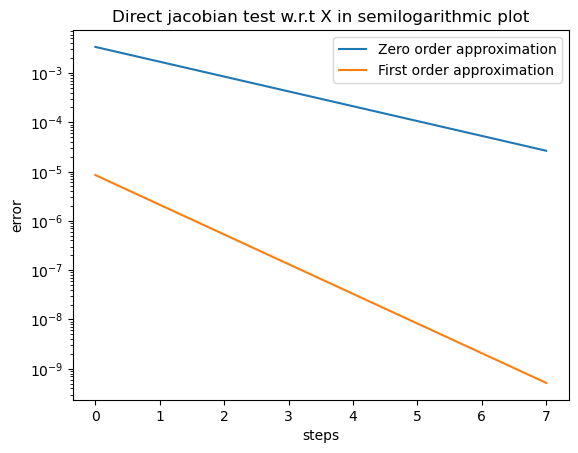

step      error order 1                 error order 2                 
0         0.03205275353498804           0.0004465168206149034         
1         0.01591962567968297           0.00011650732249639945        
2         0.007931287350602223          2.9728172008938042e-05        
3         0.003958286206116934          7.506616820291898e-06         
4         0.0019772757313512024         1.88593670288114e-06          
5         0.0009881675392942602         4.7264197009953476e-07        
6         0.0004939657537195719         1.1830505749154362e-07        
7         0.0002469533186561512         2.9594325111066515e-08        



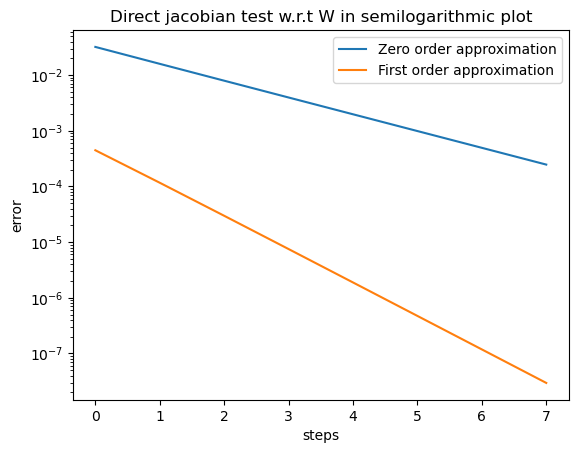

jacobian tests for layer 1
------------------------------
step      error order 1                 error order 2                 
0         0.0023681731275060347         3.4107562169575015e-05        
1         0.0011755810691709417         8.548286502711895e-06         
2         0.0005856561006942138         2.1397093600988328e-06        
3         0.00029229345041637683        5.352547493193711e-07         
4         0.00014601295230244615        1.3385446891742234e-07        
5         7.297301762269198e-05         3.346870592761718e-08         
6         3.647814227036861e-05         8.36781198642494e-09          
7         1.8236979261634922e-05        2.0920324438311296e-09        



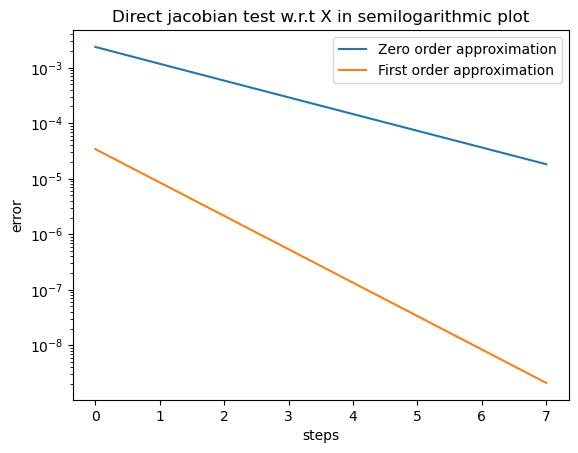

step      error order 1                 error order 2                 
0         0.02608755626716354           9.309710013448783e-05         
1         0.013020961378702664          2.3731795188138352e-05        
2         0.006504604312442985          5.989520685722484e-06         
3         0.0032508118099019573         1.504414023325868e-06         
4         0.0016250306783558016         3.76980416485909e-07          
5         0.0008124212035435646         9.435457390676461e-08         
6         0.00040618702680306207        2.3602318233140965e-08        
7         0.00020308761453077806        5.902288363596577e-09         



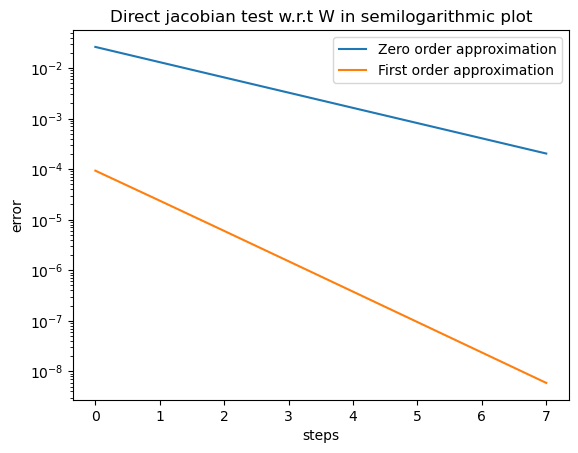

tests for classification layer
------------------------------
step      error order 1                 error order 2                 
0         0.00020900481009622496        1.0512246272112143e-06        
1         0.00010476534758740996        2.6266977430812336e-07        
2         5.2448358271783846e-05        6.565040907519711e-08         
3         2.6240593866688755e-05        1.6410473740766465e-08        
4         1.3124399817820986e-05        4.10235239377434e-09          
5         6.563225530165084e-06         1.025554942296012e-09         
6         3.281869157323314e-06         2.5638523037633143e-10        
7         1.6409986751675376e-06        6.409610930748155e-11         



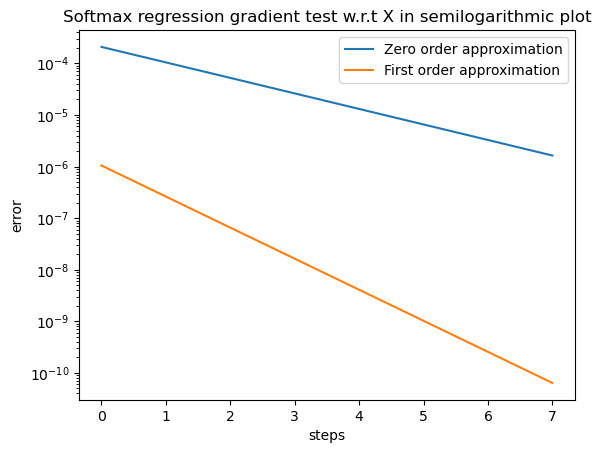

step      error order 1                 error order 2                 
0         0.052082997049007984          0.0050854162777749234         
1         0.02730848708629452           0.0012757195770969343         
2         0.013972536711245764          0.00031956662044996254        
3         0.007066085980435677          7.996568541218663e-05         
4         0.003553025795940412          2.0000036983519598e-05        
5         0.0017815118783732764         5.001038088689458e-06         
6         0.000892006073355045          1.2503848759379266e-06        
7         0.00044631561743746495        3.1261167802651424e-07        



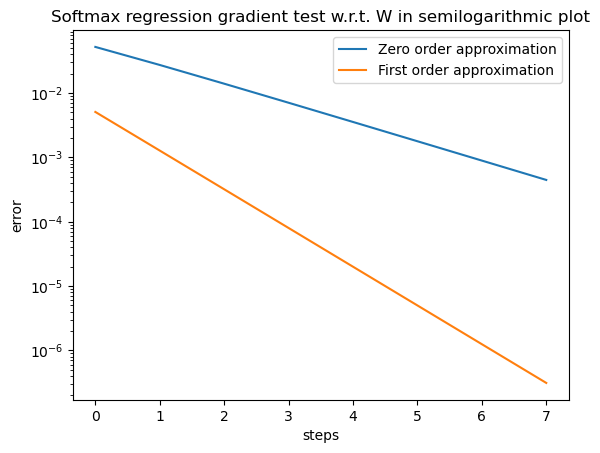

In [24]:
pure_standard_network= ClassificationNetwork(
    layers=(
        Fully_connected_layer(2, 4, np.tanh, tanh_deriv),
        Fully_connected_layer(4, 6, np.tanh, tanh_deriv),
    ),
    classes_num=2
)

pure_standard_network.do_per_layer_tests()

Since all the tests passed, we conclude that the forward function and the jacobian-transposed-times-vector calculation implementation is valid for the FC layer.

---

## Part 2.2 - Residual neural network

In this section we will implement the residual neural network building blocks.

<br/>

#### Forward pass

The forward pass of the residual neural network is defined as follows:

$$
x^{(l+1)} = f(\{ W_1^{(l)}, W_2^{(l)}, b_1^{(l)}, b_2^{(l)}\}, x_i^{(l)}) = x^{(l)} + W_2 ^{(l)}\sigma(W_1^{(l)} x_i^{(l)}+b_1^{(l)}) + b_2
$$

Where,

- $(l)$ represents the current layer
- $W_1^{(l)}$, $W_2^{(l)}$  are the weights' matrices of layer $l$ 
- $b_1^{(l)}$, $b_2^{(l)}$ are the biases of layer $l$ 
- $x^{(l)}$ is neurons of layer $l$ 
- $\sigma$ is an activation function<span style='font-size:large'>.</span>

**Note:** Here as well, we consider the bias computation as a column in the weights matrix

<br/>

#### Backward pass

for a given vector $v$, we get:

with respect to $W_2$ :

$$
{\frac{\partial f}{\partial W_2}}^Tv = v\space\sigma(W_1X + b_1)^T
$$

with respect to $W_1$:

$$
{\frac{\partial f}{\partial W_1}}^Tv = \left[\sigma'(W_1X + b_1)\odot(W_2^T v)\right]X^T
$$

with respect to $X$ :

$$
{\frac{\partial f}{\partial X}}^Tv = v+W_1^T\left[ \sigma ' \left(W_1X + b_1 \right)\odot (W_2^Tv)\right]
$$



In [25]:
class Residual_layer():
    def __init__(self, sample_size, inner_dimention, activation, activation_deriv):
        self.input_sample_size = sample_size
        self.output_sample_size = sample_size
        
        self.W2 = randn_norm_1((sample_size, inner_dimention + 1))
        self.W1 = randn_norm_1((inner_dimention, sample_size + 1))
        self.activation = activation
        self.activation_deriv = activation_deriv
        
        self.last_X = np.nan
    
    
    def parameterized_forward(self, W2, W1, activation, X):
        return X + W2 @ add_ones_row(activation(W1 @ add_ones_row(X)))
    
        
    def forward(self, X):
        self.last_X = X
        
        return self.parameterized_forward(self.W2, self.W1, self.activation, X)
    
    
    def calculate_jacobians_transposed_mult_v(self, W2, W1, X, activation, activation_deriv, v):
        jacobian_transposed_wrt_W2_mult_v = v @ add_ones_row(activation(W1 @ add_ones_row(X))).T
        jacobian_transposed_wrt_W1_mult_v = (np.multiply(activation_deriv(W1 @ add_ones_row(X)), W2[:, :-1].T @ v)) @ add_ones_row(X).T
        jacobian_transposed_wrt_X_mult_v = v + W1[:, :-1].T @ (np.multiply(activation_deriv(W1 @ add_ones_row(X)), W2[:, :-1].T @ v))

        return jacobian_transposed_wrt_W2_mult_v, jacobian_transposed_wrt_W1_mult_v, jacobian_transposed_wrt_X_mult_v
    
    
    def backward(self, v):
        jacobians_mult_v = self.calculate_jacobians_transposed_mult_v(self.W2, self.W1, self.last_X, self.activation, self.activation_deriv, v)
        
        gradients = jacobians_mult_v[:2]
        passed_down_v = jacobians_mult_v[2]
        
        return gradients, passed_down_v
        
    
    def get_weights_count(self):
        return np.prod(self.W2.shape) + np.prod(self.W1.shape)
    
    
    def update_weights(self, gradients, learning_rate):
        self.W2 -= learning_rate * gradients[0]
        self.W1 -= learning_rate * gradients[1]
    

    def do_direct_jacobian_transposed_test_wrt_w1(self):
        W1 = self.W1
        
        datapoints_num = 7
        X = layer_direct_jacobian_transposed_random_data(W1, datapoints_num)

        u = randn_norm_1(X.shape)
        
        f = lambda t: self.parameterized_forward(self.W2, t, np.tanh, X)
        g = lambda t: np.vdot(f(t), u)
        grad_g = lambda t: self.calculate_jacobians_transposed_mult_v(self.W2, t, X, np.tanh, tanh_deriv, u)[1]

        do_gradient_test(g, grad_g, W1, "Direct jacobian test w.r.t resnet W1 in semilogarithmic plot")
        
    
    def do_direct_jacobian_transposed_test_wrt_w2(self):
        W2 = self.W2
        
        datapoints_num = 7
        X = layer_direct_jacobian_transposed_random_data(self.W1, datapoints_num)

        u = randn_norm_1(X.shape)
        
        f = lambda t: self.parameterized_forward(t, self.W1, np.tanh, X)
        g = lambda t: np.vdot(f(t), u)
        grad_g = lambda t: self.calculate_jacobians_transposed_mult_v(t, self.W1, X, np.tanh, tanh_deriv, u)[0]

        do_gradient_test(g, grad_g, W2, "Direct jacobian test w.r.t resnet W2 in semilogarithmic plot")
        
        
    def do_direct_jacobian_transposed_test_wrt_x(self):
        datapoints_num = 7
        X = layer_direct_jacobian_transposed_random_data(self.W1, datapoints_num)

        u = randn_norm_1(X.shape)
        f = lambda t: self.parameterized_forward(self.W2, self.W1, np.tanh, t)
        
        g = lambda t: np.vdot(f(t), u)
        grad_g = lambda t: self.calculate_jacobians_transposed_mult_v(self.W2, self.W1, t, np.tanh, tanh_deriv, u)[2]

        do_gradient_test(g, grad_g, X, "Direct jacobian test w.r.t resnet X in semilogarithmic plot")
        
        
    def do_direct_jacobian_transposed_tests(self):
        self.do_direct_jacobian_transposed_test_wrt_x()
        self.do_direct_jacobian_transposed_test_wrt_w1()
        self.do_direct_jacobian_transposed_test_wrt_w2()
    

##### Jacobian tests of the layers
Performed on an example network of 2 residual layers

jacobian tests for layer 0
------------------------------
step      error order 1                 error order 2                 
0         0.005225701319617748          6.6856467666708e-07           
1         0.002613018991551641          1.659505955665594e-07         
2         0.0013065511325557333         4.1338517870522645e-08        
3         0.0006532859195678142         1.031596898767688e-08         
4         0.0003266455411099489         2.5766584520322752e-09        
5         0.00016332341501112957        6.438730709083622e-10         
6         8.166186851044088e-05         1.609316593561335e-10         
7         4.0830974492589434e-05        4.022846068578705e-11         



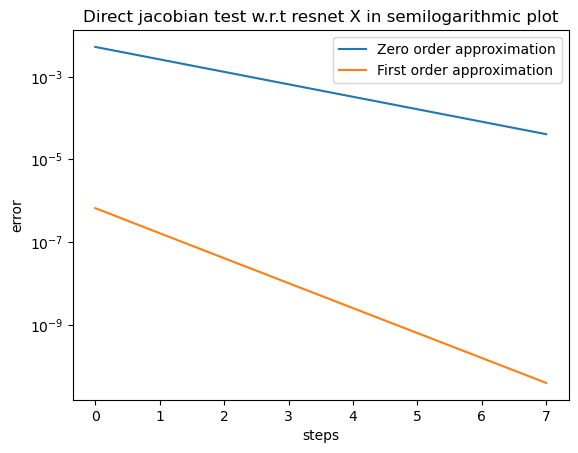

step      error order 1                 error order 2                 
0         0.005301572853521508          7.74547009079439e-06          
1         0.0026490928682557646         2.179176540407883e-06         
2         0.0013240320130657457         5.751672080673252e-07         
3         0.0006618760119179445         1.475889891053555e-07         
4         0.00033090158336893105        3.737190451145924e-08         
5         0.00016544150804034818        9.402308138388004e-09         
6         8.271841085974452e-05         2.357993639619726e-09         
7         4.1358616858555575e-05        5.904255031256465e-10         



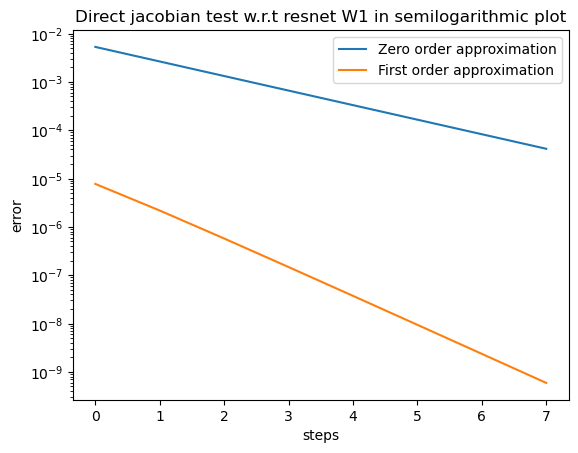

step      error order 1                 error order 2                 
0         0.006436320117570116          6.591949208711867e-17         
1         0.003218160058785058          3.2959746043559335e-17        
2         0.00160908002939264           1.2750217548429532e-16        
3         0.000804540014696431          1.7477339020466331e-16        
4         0.0004022700073482155         8.738669510233166e-17         
5         0.00020113500367424653        1.824712256293104e-16         
6         0.00010056750183717877        1.4674676404591303e-16        
7         5.02837509186449e-05          1.2888453325421434e-16        



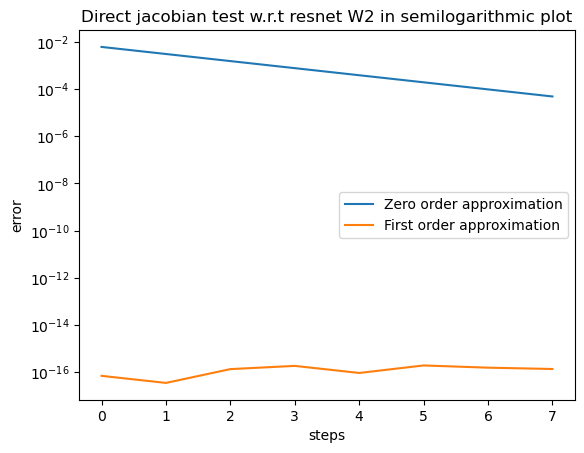

jacobian tests for layer 1
------------------------------
step      error order 1                 error order 2                 
0         0.002449574013777822          1.5481678400401308e-06        
1         0.0012243966313894572         3.837084205661999e-07         
2         0.0006121019711592957         9.550967485015376e-08         
3         0.0003060270559366307         2.3825194407959237e-08        
4         0.00015300756513891844        5.949767807069111e-09         
5         7.650229431099831e-05         1.4866254426212835e-09        
6         3.8250775397152825e-05        3.715543749814544e-10         
7         1.9125294797306402e-05        9.287591748056772e-11         



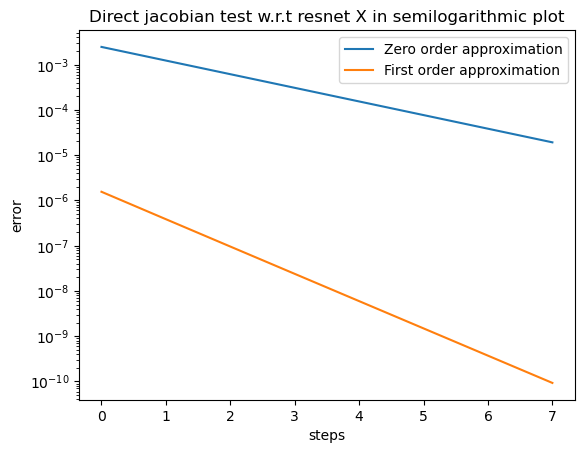

step      error order 1                 error order 2                 
0         0.0002525290676053116         2.697202817529795e-05         
1         0.00011928038704595023        6.501867330943419e-06         
2         5.798445719479295e-05         1.5951973372895425e-06        
3         2.8589639587239812e-05        3.950096584881092e-07         
4         1.4195593356192138e-05        9.827839181628612e-08         
5         7.073167809568126e-06         2.4510327380200288e-08        
6         3.530448912769657e-06         6.120171675694106e-09         
7         1.7636934870335352e-06        1.5291164865537878e-09        



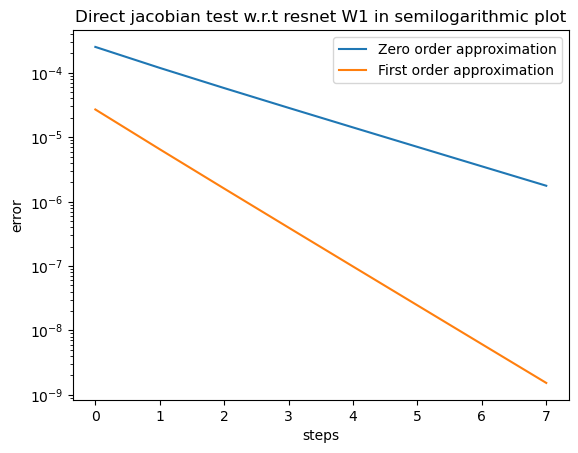

step      error order 1                 error order 2                 
0         0.030328772535429427          5.898059818321144e-17         
1         0.015164386267714602          8.153200337090993e-17         
2         0.007582193133857329          1.3010426069826053e-17        
3         0.0037910965669287755         1.0451708942760263e-16        
4         0.0018955482834641657         1.6978606021123e-16           
5         0.0009477741417320829         8.4893030105615e-17           
6         0.00047388707086609694        1.3064636178450328e-17        
7         0.00023694353543313174        8.97990449361119e-17          



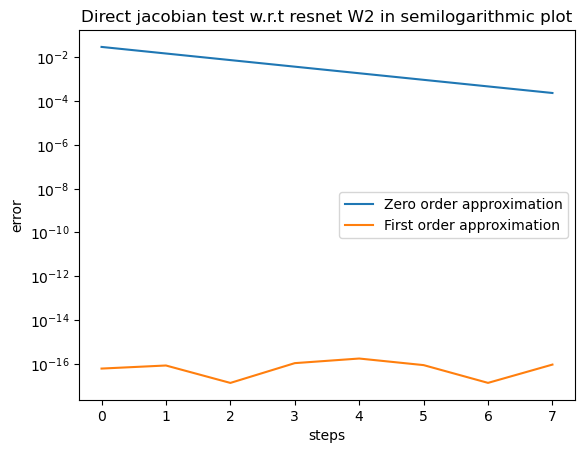

tests for classification layer
------------------------------
step      error order 1                 error order 2                 
0         0.0012526102639824899         6.819574119869406e-06         
1         0.0006280089418400081         1.7059772111715317e-06        
2         0.0003144308301634702         4.266293621196424e-07         
3         0.00015732205556506784        1.0667419772706732e-07        
4         7.868769422536559e-05         2.6670656031864914e-08        
5         3.935051451353644e-05         6.6679271622886445e-09        
6         1.9676924205125346e-05        1.6670152240179923e-09        
7         9.838878852086452e-06         4.1675808822953786e-10        



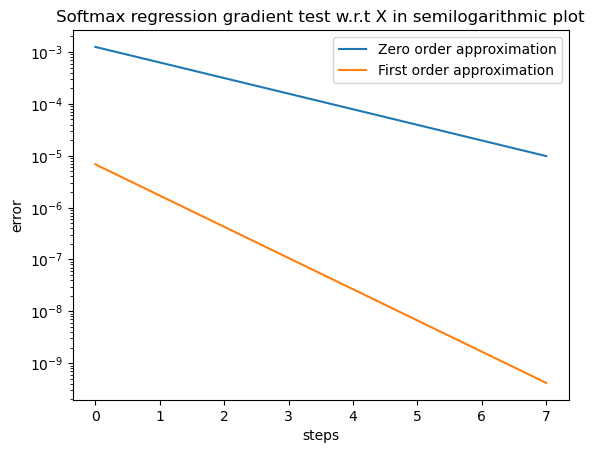

step      error order 1                 error order 2                 
0         0.19260673909077708           0.007620917030556618          
1         0.09816108052642525           0.0019527475342416            
2         0.049563023128230466          0.0004938909021029586         
3         0.024904289318713246          0.00012416769645346576        
4         0.012483100947345616          3.1127560237740465e-05        
5         0.006249321739872027          7.792513919651148e-06         
6         0.0031266076755831484         1.9494513126905658e-06        
7         0.0015637910355907891         4.875278571303716e-07         



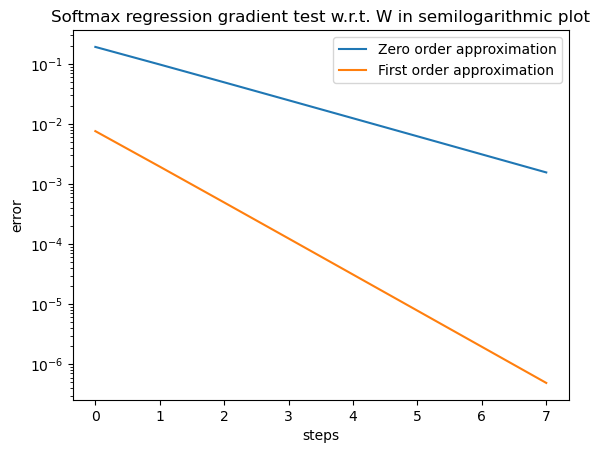

In [26]:
pure_residual_network= ClassificationNetwork(
    layers=(
        Residual_layer(8, 10, np.tanh, tanh_deriv),
        Residual_layer(8, 10, np.tanh, tanh_deriv),
    ),
    classes_num=2
)

pure_residual_network.do_per_layer_tests()

Since all the tests passed, we conclude that the forward function and the jacobian-transposed-times-vector calculation implementation is valid for the residual layer.

---
### Part 2.3

The goal in this part it to combine the pervious parts, and examine that the combination works.



##### Testing of the network as a whole
Performed on 3 example networks:
- purely FC network
	- gradient test of the network w.r.t. $W$
- purely Residual network
	- gradient test of the network w.r.t. $W$
- mixed
	- per-layer jacobian tests
    - gradient test of the network w.r.t. $W$


##### Purely FC network test

step      error order 1                 error order 2                 
0         0.0044713911953467855         0.0005499485875675369         
1         0.002095540398546203          0.00013481909465657858        
2         0.0010137379787987788         3.337732685396665e-05         
3         0.0004984841034781917         8.303777505785643e-06         
4         0.0002471610615510933         2.070898564890259e-06         
5         0.0001230621768718576         5.1709537875609e-07           
6         6.140173602486865e-05         1.2919527831788764e-07        
7         3.0668559377833304e-05        3.228900455792453e-08         



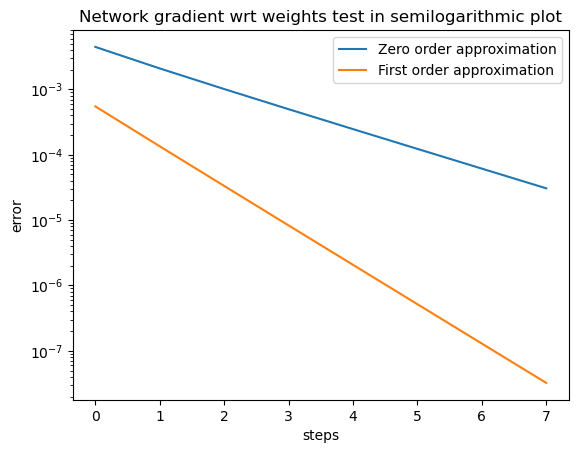

In [27]:
pure_standard_network.do_gradient_test_wrt_w()

##### Purely Residual network


step      error order 1                 error order 2                 
0         0.009551881254139416          0.00013319629977429429        
1         0.004806422672814947          3.611610414190787e-05         
2         0.0024118740589191834         9.395329559244193e-06         
3         0.0012082391890094746         2.3955052297392095e-06        
4         0.000604712581407596          6.047657120109105e-07         
5         0.00030250674249965304        1.519310601504108e-07         
6         0.0001512912613448325         3.807543506921746e-08         
7         7.565513793406087e-05         9.530455889994157e-09         



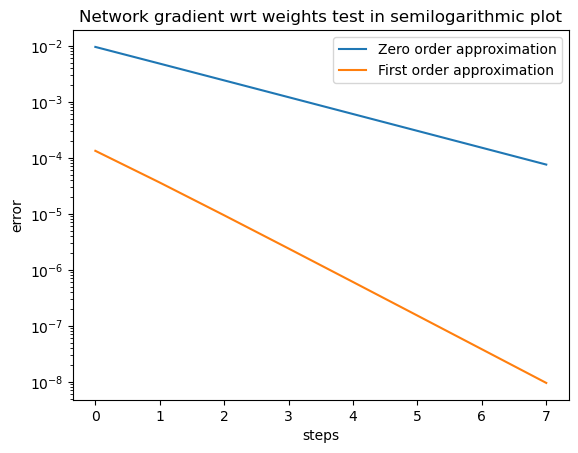

In [28]:
pure_residual_network.do_gradient_test_wrt_w()


##### Mixed network


jacobian tests for layer 0
------------------------------
step      error order 1                 error order 2                 
0         0.018526242502829304          4.462720990215663e-07         
1         0.009263234095784334          1.1029167982894161e-07        
2         0.004631644780411226          2.7413320855505796e-08        
3         0.0023158292634888333         6.833377207398489e-09         
4         0.001157916342583054          1.7058499662738619e-09        
5         0.0005789585980657264         4.2615078382334665e-10        
6         0.00028947940560952734        1.0649872775108857e-10        
7         0.0001447397294343511         2.6619776451490204e-11        



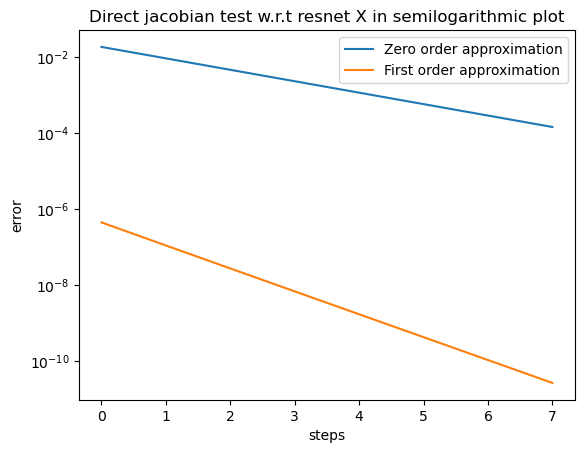

step      error order 1                 error order 2                 
0         0.007700367673316499          4.373494111074069e-05         
1         0.003861391302692363          1.0660004521257076e-05        
2         0.0019333954906814999         2.6301629253101724e-06        
3         0.0009673596780290783         6.531487743267157e-07         
4         0.00048384367747256185        1.6273592914065526e-07        
5         0.00024196259176667567        4.061493417558087e-08         
6         0.00012099145825650304        1.0145093922589248e-08        
7         6.0498266482023055e-05        2.5351931897578807e-09        



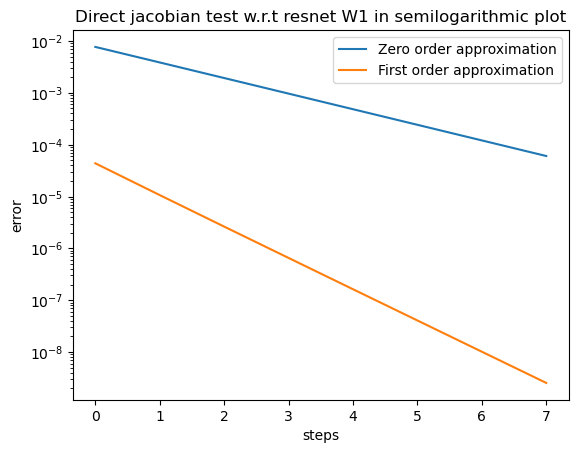

step      error order 1                 error order 2                 
0         0.00130877766481019           1.214306433183765e-16         
1         0.0006543888324053171         2.8275992658421956e-16        
2         0.00032719441620265854        1.4137996329210978e-16        
3         0.00016359720810155132        2.927345865710862e-16         
4         8.179860405088668e-05         2.5738959574805875e-16        
5         4.089930202533232e-05         1.7672495411513722e-17        
6         2.0449651012999226e-05        3.419031550933038e-16         
7         1.0224825506721658e-05        3.929961824716832e-16         



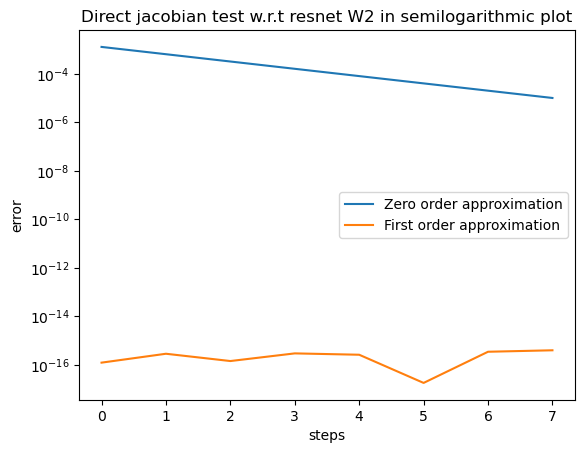

jacobian tests for layer 1
------------------------------
step      error order 1                 error order 2                 
0         0.0063863271857012086         6.0674811766655776e-06        
1         0.0031946798309509528         1.5175024879843062e-06        
2         0.0015977192137919712         3.794529274973781e-07         
3         0.0007989544605752665         9.487278446781554e-08         
4         0.0003995009472966271         2.3719383240026256e-08        
5         0.0001997564033462372         5.929993696361961e-09         
6         9.987968415313409e-05         1.4825168326981905e-09        
7         4.994021270348856e-05         3.706314948348564e-10         



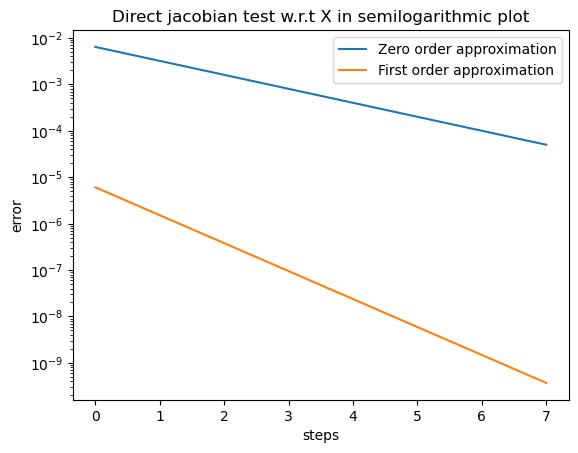

step      error order 1                 error order 2                 
0         0.00026585917083796207        1.4870990311940252e-05        
1         0.00013612703252680047        4.238048048150686e-06         
2         6.905862282119424e-05         1.123917466281342e-06         
3         3.4802282358137315e-05        2.8898778560047453e-07        
4         1.7472389799266796e-05        7.324527260209844e-08         
5         8.754381600042938e-06         1.843593589150993e-08         
6         4.3817842177579225e-06        4.6245502093012446e-09        
7         2.1920463012387037e-06        1.158082744908166e-09         



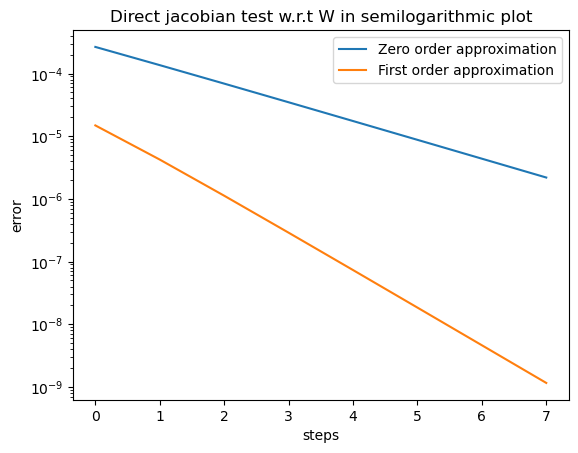

tests for classification layer
------------------------------
step      error order 1                 error order 2                 
0         5.207174668342418e-05         1.3380645204684287e-06        
1         2.6369673556292383e-05        3.3523204565392116e-07        
2         1.3268555062673215e-05        8.389773829993712e-08         
3         6.6552407345099596e-06        2.0985665976616576e-08        
4         3.3328653792352725e-06        5.247821008015586e-09         
5         1.6677444687474008e-06        1.3121313742432477e-09        
6         8.342002448813446e-07         3.280551794774297e-10         
7         4.171821328391445e-07         8.201719126649395e-11         



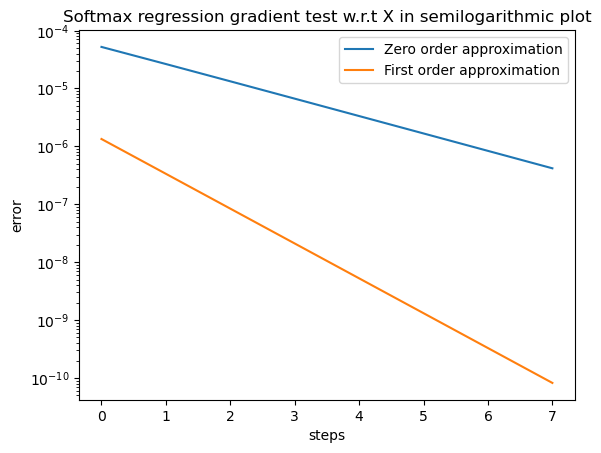

step      error order 1                 error order 2                 
0         0.0455664319225173            0.001073782592125122          
1         0.022518636648463097          0.0002723119832670068         
2         0.01119214344324515           6.898111064710527e-05         
3         0.005578966632112881          1.7385465813857942e-05        
4         0.0027851562218024206         4.365638652909301e-06         
5         0.0013914892210364904         1.093929461734762e-06         
6         0.0006954714500997383         2.7380431236049066e-07        
7         0.0003476673146525222         6.849175883329346e-08         



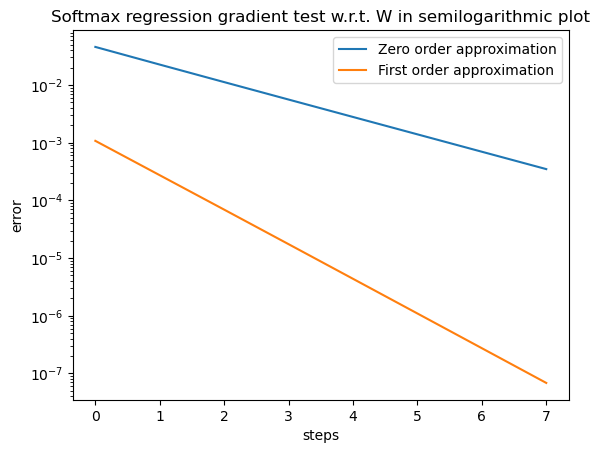

In [29]:
mixed_network = ClassificationNetwork(
    layers=(
        Residual_layer(8, 10, np.tanh, tanh_deriv),
        Fully_connected_layer(8, 8, np.tanh, tanh_deriv),
    ),
    classes_num=2
)

mixed_network.do_per_layer_tests()

step      error order 1                 error order 2                 
0         0.0062869083439544005         0.0003821713724664064         
1         0.003047560540851424          9.519205510742689e-05         
2         0.0014999365862483627         2.3752343376364166e-05        
3         0.0007440243914987876         5.9322700627883725e-06        
4         0.0003705283947851301         1.4823340671304822e-06        
5         0.00018489352179640317        3.704914374033565e-07         
6         9.235412650410169e-05         9.261132460177855e-08         
7         4.6153908977553115e-05        2.3151387803161717e-08        



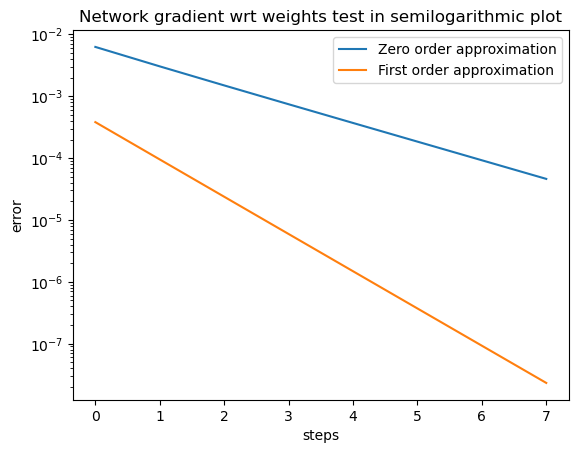

In [30]:
mixed_network.do_gradient_test_wrt_w()

Since all the tests passed, we conclude that the implementation for the forward and backward passes of the entire network is valid.

---
## Part 2.4

### Experiments
We will try to compare the effects of the following hyper-parameters on the network's performance:

- number of used layers
- whether the residual layers were used

<br/>

To test the effect of the number of layers, we chose to train 3 networks:

- architecture 1: 
	- a fully-connected layer 
	- a softmax layer
- architecture 2:
	- a  fully-connected layer 
    - a residual-connection layer
    - a softmax layer
- architecture 3:
	- a  fully-connected layer 
    - 3 residual-connection layer
    - a softmax layer

<br/>

To test the effect of usage of residual layers, we chose to train 2 networks:

- architecture 1: 
	- 3 fully-connected layer 
	- a softmax layer
- architecture 2:
	- a fully-connected layer 
	- a residual-connection layer
	- a softmax layer
    
<br/>

Training hyper-parameters were decided to be the same for all optimizations:

- epochs: 250
- minibatch size: 64
- initial learning rate: 1e-1
- learning rate decay rate: every 50 epochs
- learning rate decay factor: 0.8

Slightly modifying the SGD implementation from before to be able to use network objects

In [31]:
def network_SGD(X_train, Y_train, X_val, Y_val, network, epochs=500, minibatch_size=64, learning_rate=1e-3, update_every=50, update_factor=0.8):
    datapoint_size, datapoints_num = X_train.shape
    classes_num, datapoints_num = Y_train.shape

    # subsample size for measuring success
    subsample_size = 0.05 # 5 percent
    X_train_sub, Y_train_sub, _, _ = randomly_split_dataset(X_train, Y_train, split_percentage = subsample_size)
    X_val_sub, Y_val_sub, _, _ = randomly_split_dataset(X_val, Y_val, split_percentage = subsample_size)
    
    train_losses, train_successes = list(), list()
    val_losses, val_successes = list(), list()
    
    for epoch_num in range(1, epochs + 1):
        minibatches = epoch_generator(X_train, Y_train, minibatch_size)
        
        if epoch_num % update_every == 0: 
            learning_rate *= update_factor
        
        for (minibatch_X, minibatch_Y) in minibatches:
            network.forward_pass(minibatch_X, minibatch_Y)
            network.backward_pass(learning_rate)
            
        _, train_loss, train_success = network.forward_pass(X_train_sub, Y_train_sub)
        _, val_loss, val_success = network.forward_pass(X_val_sub, Y_val_sub)

        train_losses.append(train_loss)
        train_successes.append(train_success)

        val_losses.append(val_loss)
        val_successes.append(val_success)
            
    return train_losses, train_successes, val_losses, val_successes

In [32]:
def make_networks(X, C):
    classes_count, _ = C.shape
    datapoint_size, _ = X.shape
    
    network_comparisons = (
        {
            "1 hidden layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 20, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
            "2 hidden layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 20, np.tanh, tanh_deriv),
                    Residual_layer(20, 20, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
            "4 hidden layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 20, np.tanh, tanh_deriv),
                    Residual_layer(20, 20, np.tanh, tanh_deriv),
                    Residual_layer(20, 20, np.tanh, tanh_deriv),
                    Residual_layer(20, 20, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
        },
        {
            "with residual layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 20, np.tanh, tanh_deriv),
                    Residual_layer(20, 20, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
            "without residual layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 20, np.tanh, tanh_deriv),
                    Fully_connected_layer(20, 20, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
        },
    )
    
    return network_comparisons

As before, we provided a backup of the trained networks and their achieved results to avoid re-training, for convenience.

In [33]:
RUN_NETWORKS = False

if not RUN_NETWORKS:
    network_comparisons_dict = load_backup("2024-04-22-15-26-02-networks_result.bak")

In [34]:
if RUN_NETWORKS:
    NETWORKS_BACKUP_FILE = f"{datetime.datetime.now():%Y-%m-%d-%H-%M-%S}-networks_result.bak"
    network_comparisons_dict = defaultdict(lambda: defaultdict(dict))

    for (dataset_name, dataset) in datasets.items():
        for network_comparison in make_networks(dataset[0], dataset[1]):
            comparison_description = ' vs. '.join(network_comparison)
            
            for (attribute, network) in network_comparison.items():
                
                network_comparisons_dict[dataset_name][comparison_description][attribute] = { 
                    "network": network,
                    "results": network_SGD(
                        *dataset, network,
                        epochs=250,
                        minibatch_size=64,
                        learning_rate=1e-1,
                        update_every=50,
                        update_factor=0.8,
                    )
                }
                
                # update backup file after every completed optimization
                save_backup(network_comparisons_dict, NETWORKS_BACKUP_FILE)
        

#### Examining performance

##### Final accuracy

Same as before we'll process 10 last epochs to determine performance

In [35]:
last_epochs_considered = 10

networks_processed_dict = process_networks_comparisons(network_comparisons_dict, last_epochs_considered)

In [36]:
print_networks_comparisons(networks_processed_dict)

SwissRoll
----------------------------------------------------------------------------------------------------
	1 hidden layers vs. 2 hidden layers vs. 4 hidden layers
----------------------------------------------------------------------------------------------------
		| 1 hidden layers        | 2 hidden layers        | 4 hidden layers        | 
....................................................................................................
		| 68.92                  | 97.56                  | 97.2                   | 
----------------------------------------------------------------------------------------------------
	with residual layers vs. without residual layers
----------------------------------------------------------------------------------------------------
		| with residual layers   | without residual layers | 
....................................................................................................
		| 97.4                   | 94.68                  | 
Peaks


It seems that with the exception of "1 hidden layer" versions of Swissroll and Peaks most networks performed fairly well.

Hard to draw conclusions from only the final results.

##### Loss and classification success as function of epoch, for the comparisons for each dataset

SwissRoll
----------------------------------------------------------------------------------------------------
	1 hidden layers vs. 2 hidden layers vs. 4 hidden layers
----------------------------------------------------------------------------------------------------


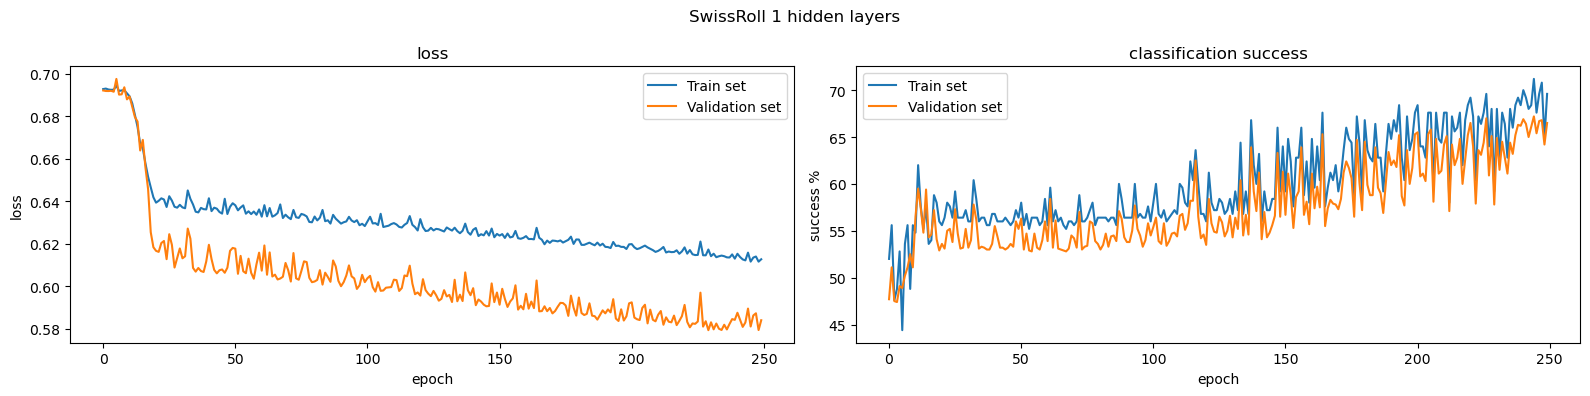

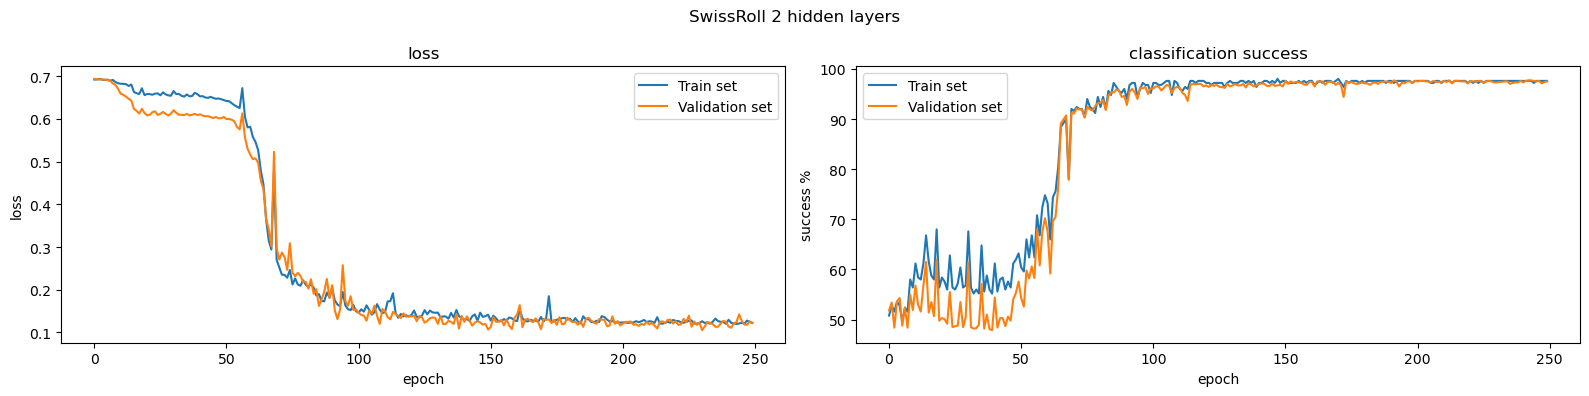

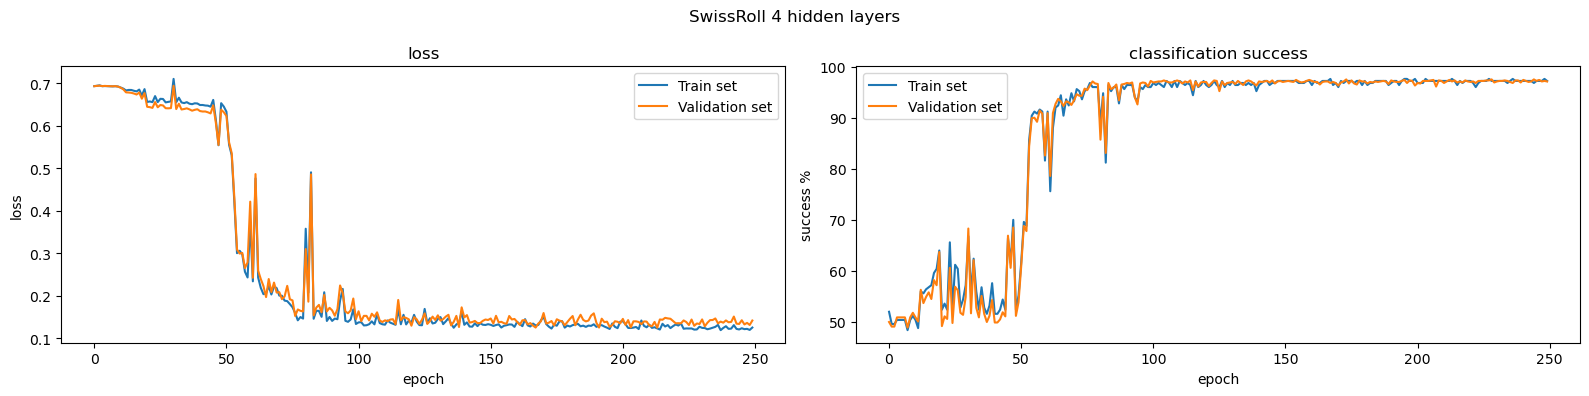

----------------------------------------------------------------------------------------------------
	with residual layers vs. without residual layers
----------------------------------------------------------------------------------------------------


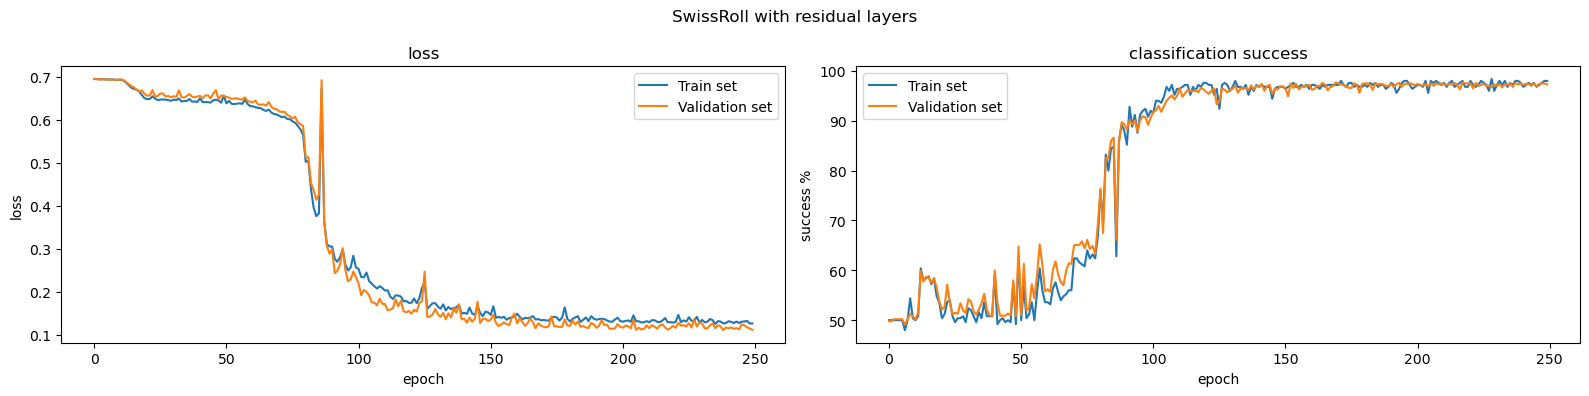

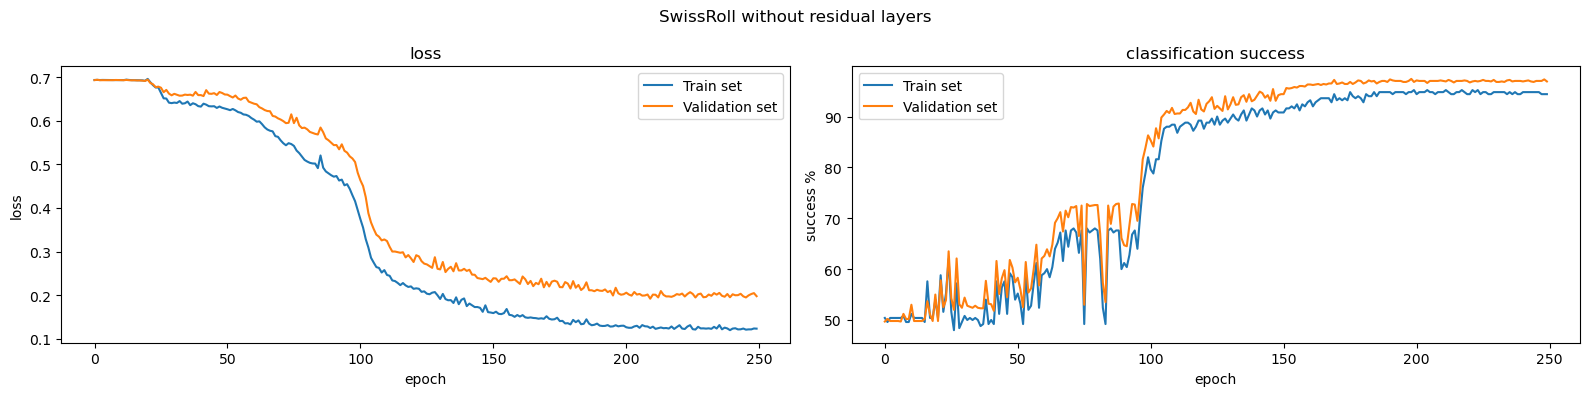

Peaks
----------------------------------------------------------------------------------------------------
	1 hidden layers vs. 2 hidden layers vs. 4 hidden layers
----------------------------------------------------------------------------------------------------


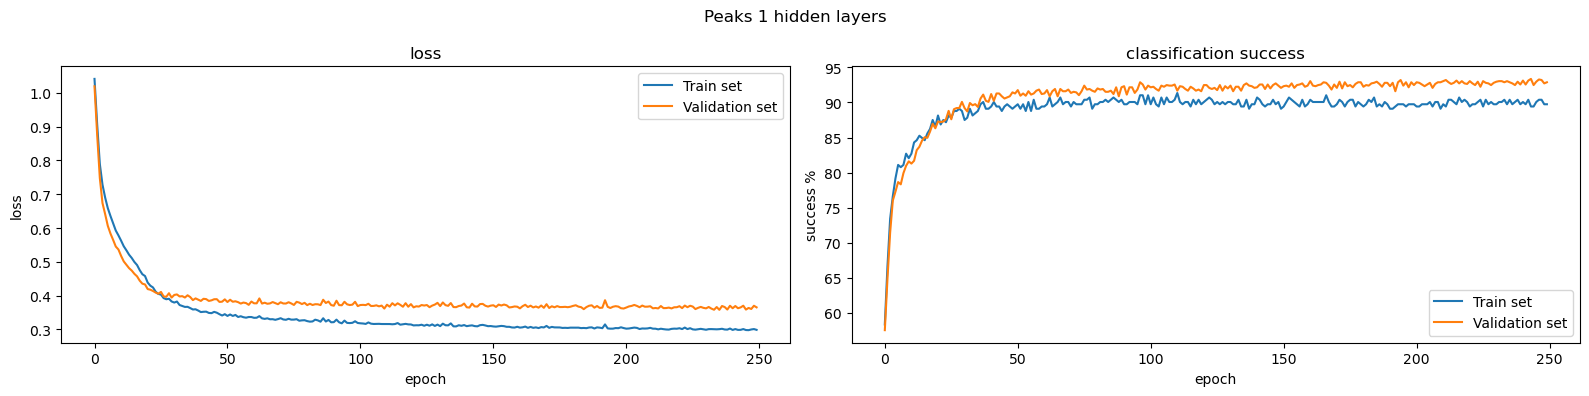

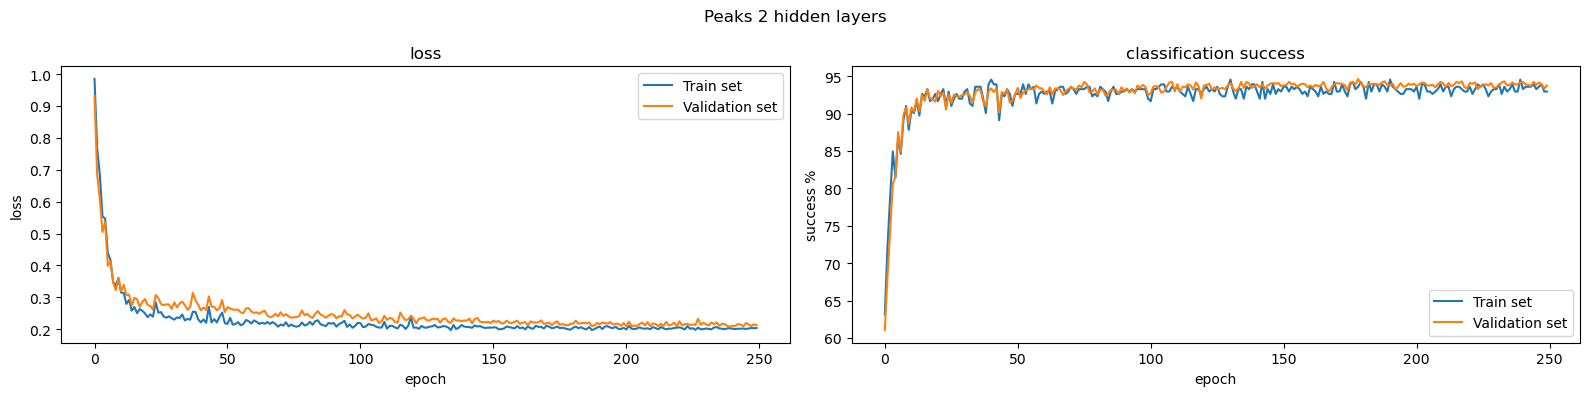

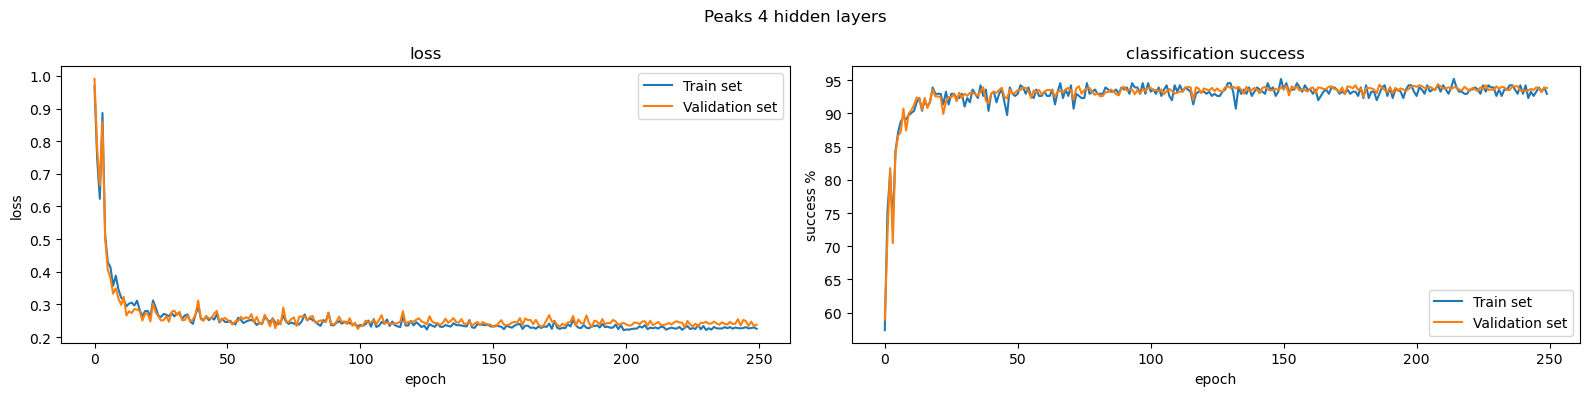

----------------------------------------------------------------------------------------------------
	with residual layers vs. without residual layers
----------------------------------------------------------------------------------------------------


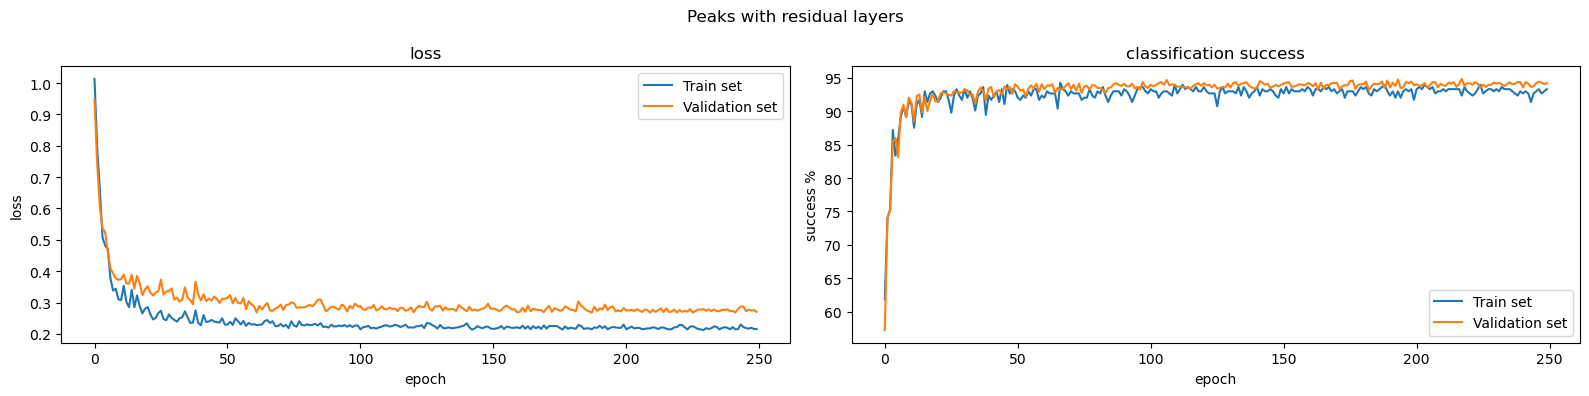

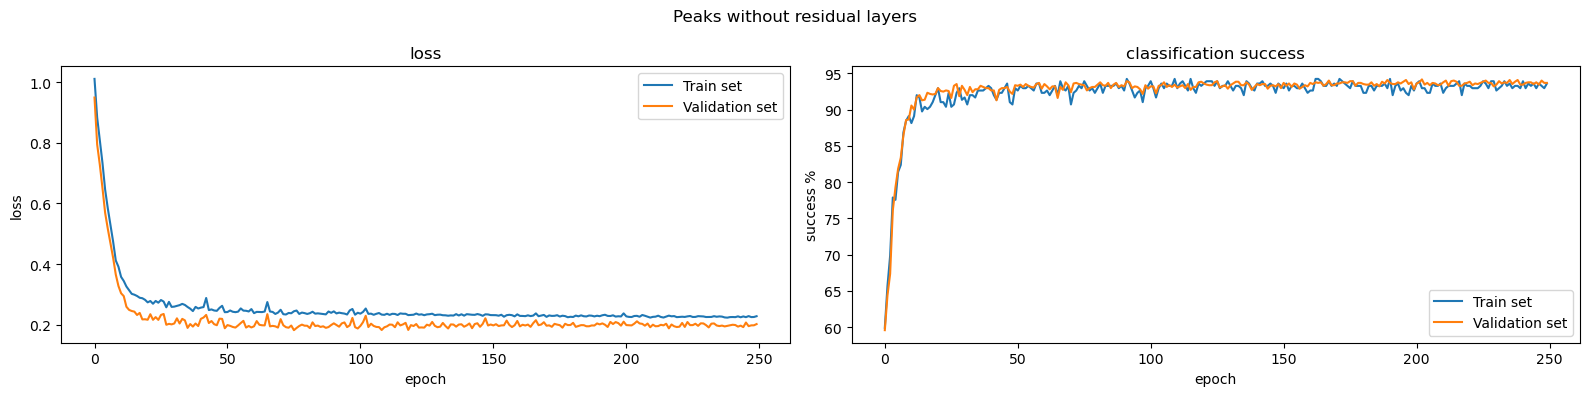

GMM
----------------------------------------------------------------------------------------------------
	1 hidden layers vs. 2 hidden layers vs. 4 hidden layers
----------------------------------------------------------------------------------------------------


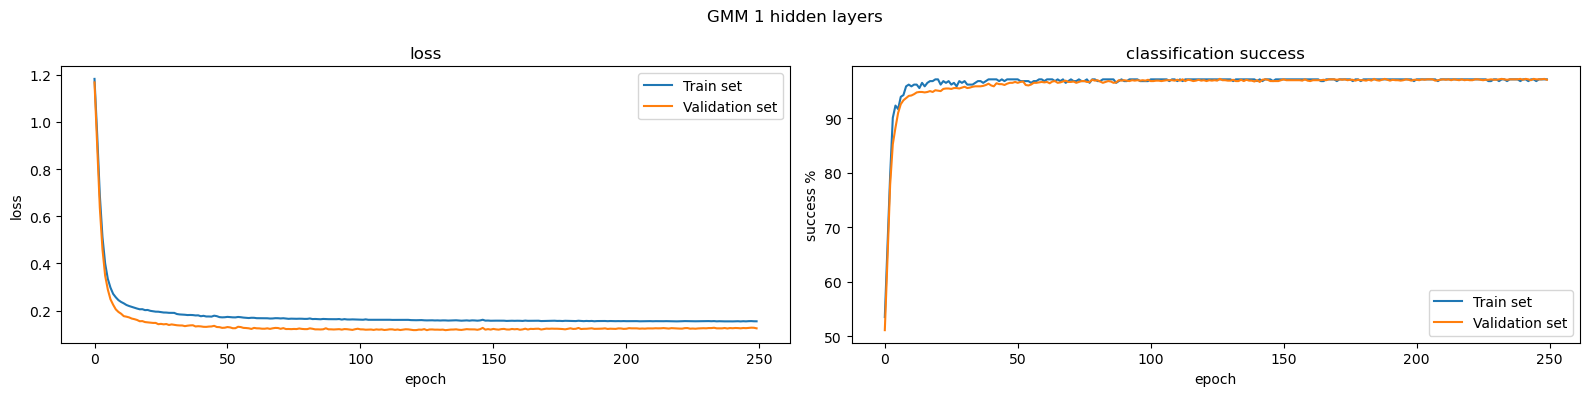

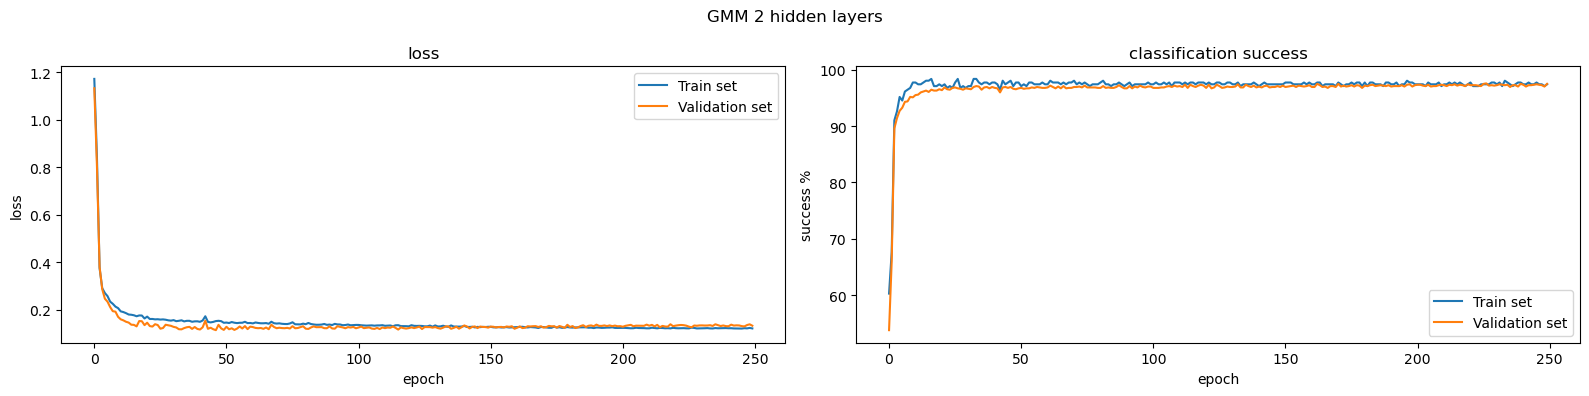

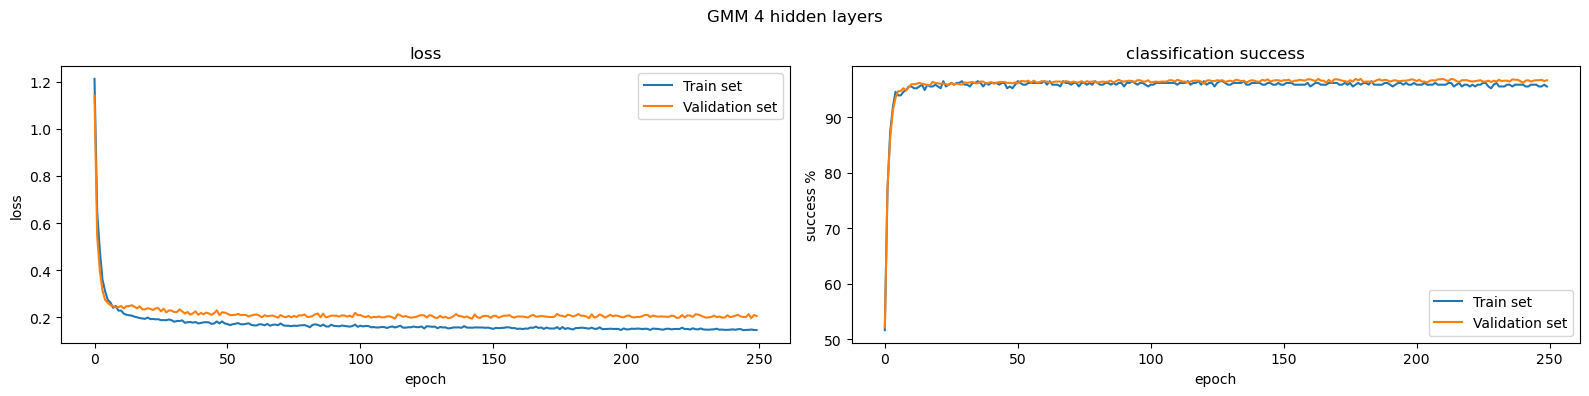

----------------------------------------------------------------------------------------------------
	with residual layers vs. without residual layers
----------------------------------------------------------------------------------------------------


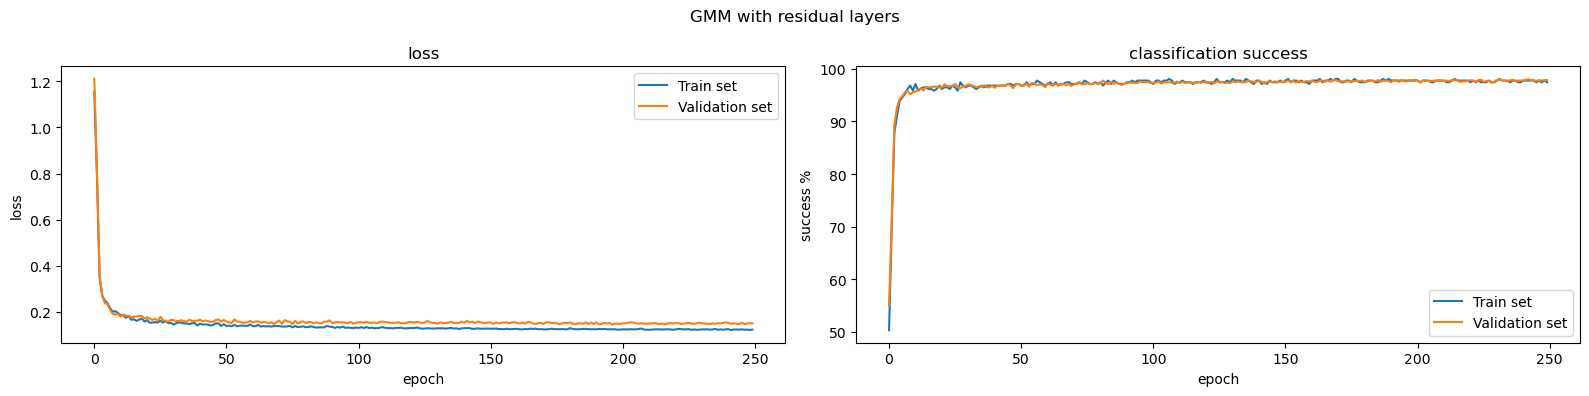

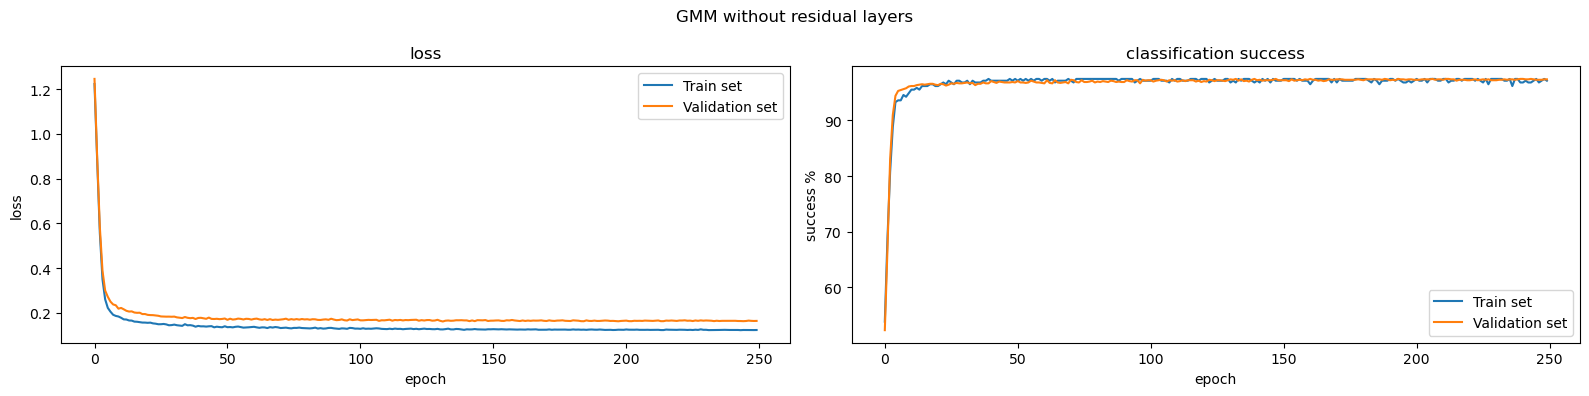

In [37]:
plot_networks_comparisons(network_comparisons_dict)

## Conclusions for 2.4
### How well does the model fit to the data?

Most networks performed well on the data, achieving high accuracy on the validation set. Thus they seem to fit well to the data.

From training process plots, it seems that the "1 hidden layer" version for the Swissroll dataset could still reach higher accuracy given more training time.

In contrast, the "1 hidden layer" version for the Peaks dataset seemed to have the generalization gap, between accuracy on validation and train sets, widen more training progress.

### Differences in performance between datasets

It seems from the plots that training networks went the smoothest for the GMM dataset, followed by Peaks, followed by Swissroll.

We think that it could be attributed to the difference in input and output dimentions. Since bigger datapoint size = more weights on the first layer, and higher class count = more weights on the last layer.

### Difference the number of layers made

For the same dataset, more layers made the minimization:
- reach high accuracy/lower loss sooner in the training process (even if didn't result in higher accuracy overall) (e.g. Swissroll 1 h.l. vs 2 h.l. vs 4 h.l.)
- minimize the generalization gap (e.g. Peaks 1 h.l. vs 2 h.l.)

We attribute that too to more layers resulting in more weights (in our experiment). This could also be caused by more non-linear transformations but our experiment wasn't designed to isolate that trait.

### Difference between using residual layers vs. not

We think that from the results we got, a definite conclusion can't be drawn, as the effect on the GMM dataset learning isn't significant enough and training on the other datasets gives contradicting results.



---
## Part 2.5



### Expriment: Using less parameters

We will repeat the previous experiment using a network of only $100C$ parameters.

We will run the experiment only for the Swissroll dataset, since the differences in training for it were more apparent previously.

Thus, we aim to only use $~200$ parameters.

<br/>

##### Networks to be used
Number of layers experiment:
- 1 hidden layer: 202 weights ($3\cdot40 + 41 \cdot 2$)
	- FC layer transforming dimention to 40
    - Softmax layer
- 2 hidden layers: 203 weights ($3 \cdot 8 + 9 \cdot 9 + 10 \cdot 8 +9 \cdot 2$)
	- FC layer transforming dimention to 8
    - Residual layer transforming dimention to 9 and back to 8
    - Softmax layer
- 4 hidden layers: 196 weights ($3 \cdot 5 + 4(6 \cdot 5) + 6 \cdot 4+5 \cdot 5 + 6 \cdot 2$)
	- FC layer transforming dimention to 5
    - Residual layer keeping dimention of 5
    - Residual layer keeping dimention of 5
    - Residual layer transforming dimention to 4 and back to 5
    - Softmax layer
    
Usage of residual layers experiment:
- with residual layers: 203 weights ($3 \cdot 8 + 9 \cdot 9 + 10 \cdot 8 +9 \cdot 2$)
	- FC layer transforming dimention to 8
    - Residual layer transforming dimention to 9 and back to 8
    - Softmax layer
- without residual layers: 203 weights ($3 \cdot 11+12 \cdot 12+13 \cdot 2$)
	- FC layer transforming dimention to 11
	- FC layer transforming dimention to 12
    - Softmax layer

In [38]:
def make_swissroll_constrained_networks():
    datapoint_size = 2
    classes_count = 2
    
    network_comparisons = (
        {
            "1 hidden layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 40, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
            "2 hidden layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 8, np.tanh, tanh_deriv),
                    Residual_layer(8, 9, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
            "4 hidden layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 5, np.tanh, tanh_deriv),
                    Residual_layer(5, 5, np.tanh, tanh_deriv),
                    Residual_layer(5, 5, np.tanh, tanh_deriv),
                    Residual_layer(5, 4, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
        },
        {
            "with residual layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 8, np.tanh, tanh_deriv),
                    Residual_layer(8, 9, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
            "without residual layers": ClassificationNetwork(
                layers=(
                    Fully_connected_layer(datapoint_size, 11, np.tanh, tanh_deriv),
                    Fully_connected_layer(11, 12, np.tanh, tanh_deriv),
                ),
                classes_num=classes_count
            ),
        },
    )
    
    return network_comparisons

#### Confirming weight-counts

In [39]:
for network_comparison in make_swissroll_constrained_networks():
        comparison_description = ' vs. '.join(network_comparison)

        for (attribute, network) in network_comparison.items():
            print(f"{attribute = :<23}:  weight-count {comparison_string(network.get_weights_count(), network_comparisons_dict['SwissRoll'][comparison_description][attribute]['network'].get_weights_count())}")
            print()
            

attribute = 1 hidden layers        :  weight-count 202 (vs. 102, +98.04%)

attribute = 2 hidden layers        :  weight-count 203 (vs. 942, -78.45%)

attribute = 4 hidden layers        :  weight-count 196 (vs. 2622, -92.52%)

attribute = with residual layers   :  weight-count 203 (vs. 942, -78.45%)

attribute = without residual layers:  weight-count 203 (vs. 522, -61.11%)



As before, can load a backup of the trained networks.

In [40]:
RUN_SWISSROLL_CONSTRAINED = False

if not RUN_SWISSROLL_CONSTRAINED:
    swissroll_constrained_dict = load_backup("2024-04-23-07-33-23-swissroll_constrained.bak")

In [41]:
if RUN_SWISSROLL_CONSTRAINED:
    SWISSROLL_CONSTRAINED_BACKUP_FILE = f"{datetime.datetime.now():%Y-%m-%d-%H-%M-%S}-swissroll_constrained.bak"
    swissroll_constrained_dict = defaultdict(lambda: defaultdict(dict))

    for network_comparison in make_swissroll_constrained_networks():
        comparison_description = ' vs. '.join(network_comparison)

        for (attribute, network) in network_comparison.items():

            swissroll_constrained_dict[comparison_description][attribute] = { 
                "network": network,
                "results": network_SGD(
                    *datasets["SwissRoll"], network,
                    epochs=250,
                    minibatch_size=64,
                    learning_rate=1e-1,
                    update_every=50,
                    update_factor=0.8,
                )
            }

            # update backup file after every completed optimization
            save_backup(swissroll_constrained_dict, SWISSROLL_CONSTRAINED_BACKUP_FILE)
            

#### Examining results
We'll compare the results gotten with the constrained architecture on Swissroll, to the ones gotten by their unconstrained counterparts from the previous experiment.

In [42]:
last_epochs_considered = 10

swissroll_processed_dict = process_constrained_swissroll(swissroll_constrained_dict, last_epochs_considered)

In [43]:
print_swissroll_constrained(swissroll_processed_dict, networks_processed_dict)

SwissRoll
----------------------------------------------------------------------------------------------------
	1 hidden layers vs. 2 hidden layers vs. 4 hidden layers
----------------------------------------------------------------------------------------------------
		| 1 hidden layers           | 2 hidden layers           | 4 hidden layers           | 
....................................................................................................
		| 55.4 (vs. 68.92, -19.62%) | 96.8 (vs. 97.56, -0.78%)  | 96.08 (vs. 97.2, -1.15%)  | 
----------------------------------------------------------------------------------------------------
	with residual layers vs. without residual layers
----------------------------------------------------------------------------------------------------
		| with residual layers      | without residual layers   | 
....................................................................................................
		| 96.28 (vs. 97.4, -1.15%)  | 96.8 (

SwissRoll
----------------------------------------------------------------------------------------------------
	1 hidden layers vs. 2 hidden layers vs. 4 hidden layers
----------------------------------------------------------------------------------------------------


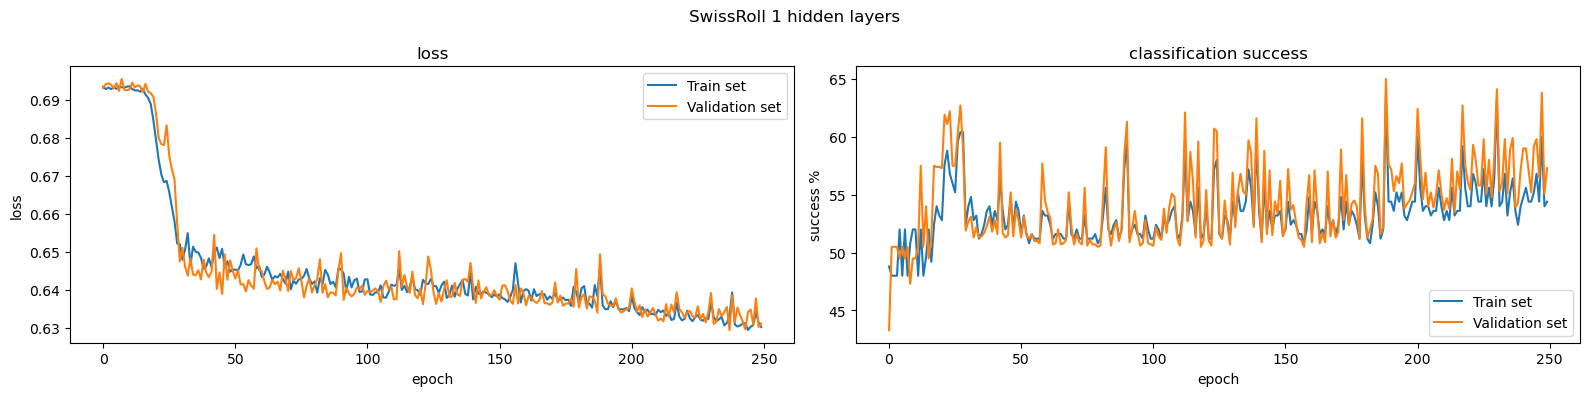

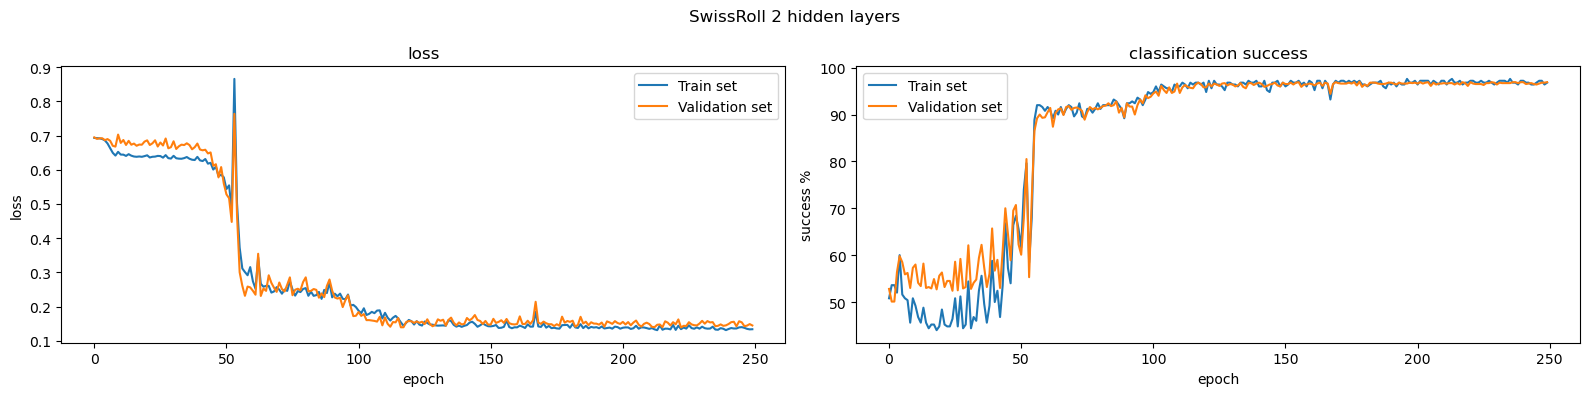

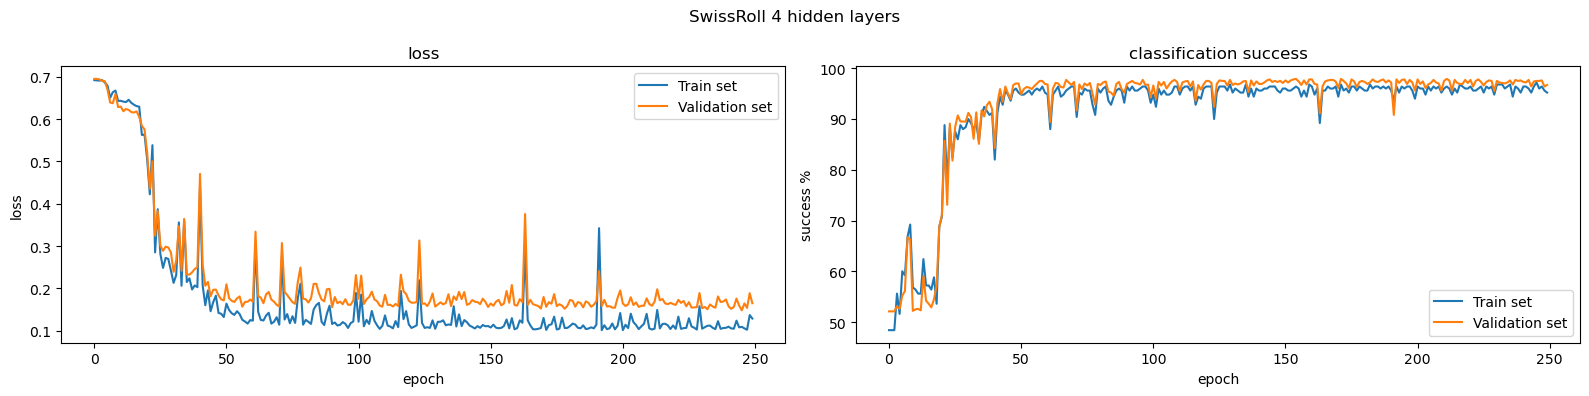

----------------------------------------------------------------------------------------------------
	with residual layers vs. without residual layers
----------------------------------------------------------------------------------------------------


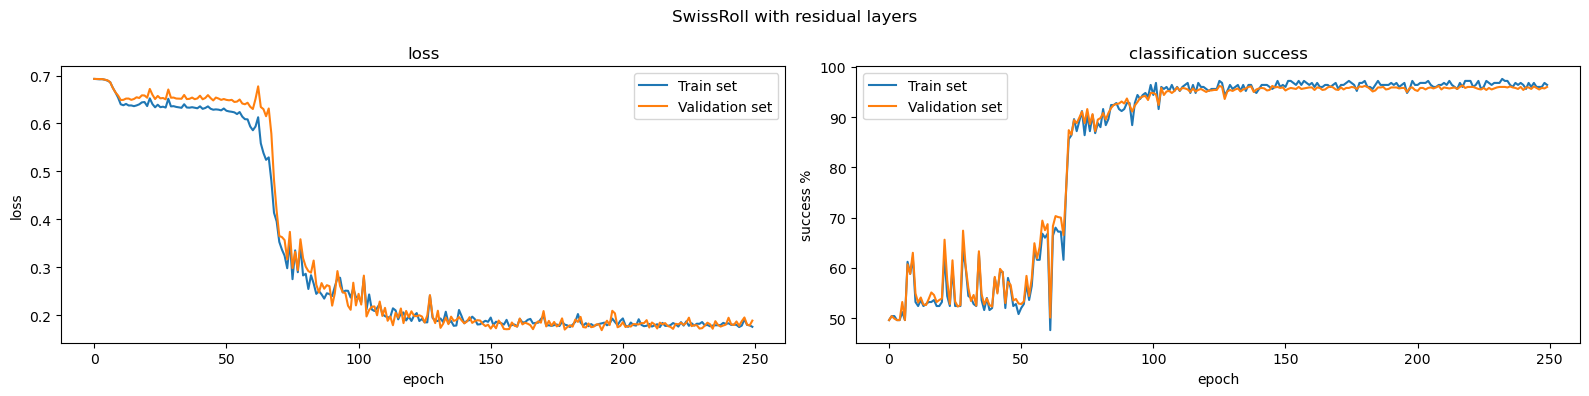

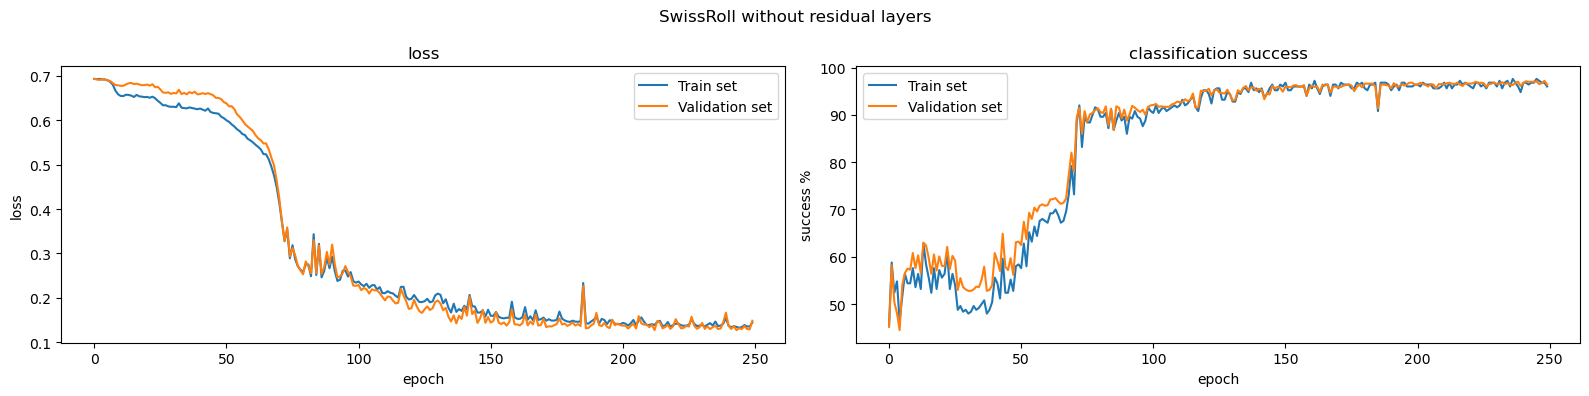

In [44]:
plot_swissroll_constrained(swissroll_constrained_dict)

### Conclusions for Part 2.5
#### Difference in achieved accuracy
Aside from the already-problematic "1 hidden layer" variant Swissroll model, all the networks displayed relatively-negligible accuracy difference from their unconstrained counterparts (sometimes even positive, although that might just stem from randomness of initialization).

Which would mean that using much less resources (up to 92% less) we were able to achieve practically the same effect.

### Difference in training process

To our surprise, except the "1 hidden layer" variant , the models' training processes were very similar in general behavior to their counterparts (albeit noisier.)

The behavior of the "1 hidden layer" variant can be chalked up to the model being unfit, since even though the new model has twice-as-many weights as the previous one, it performed worse.

---
---

## **Part 3 - Final results**

### Visualizing NN models' classification

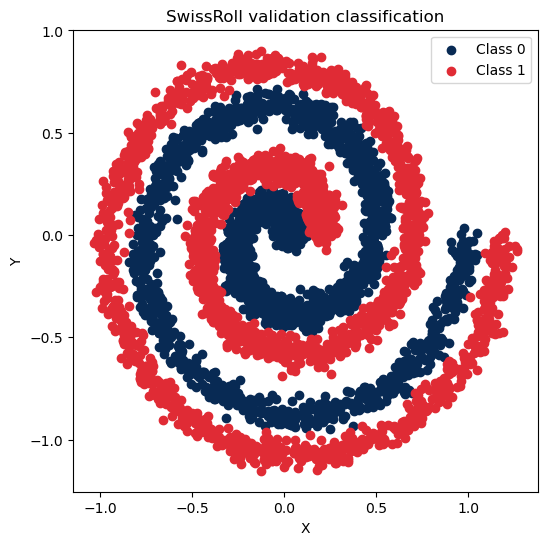

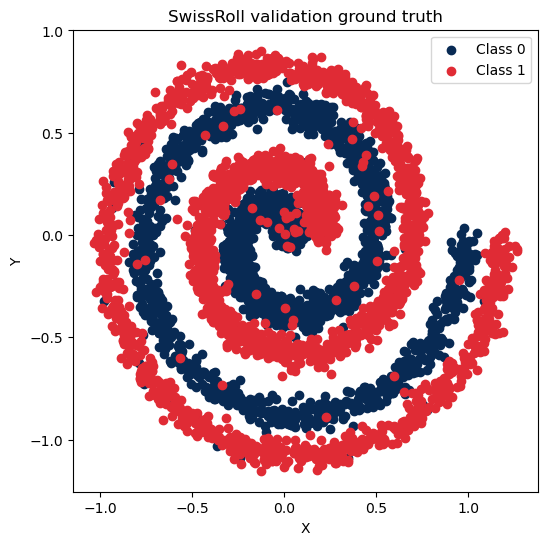

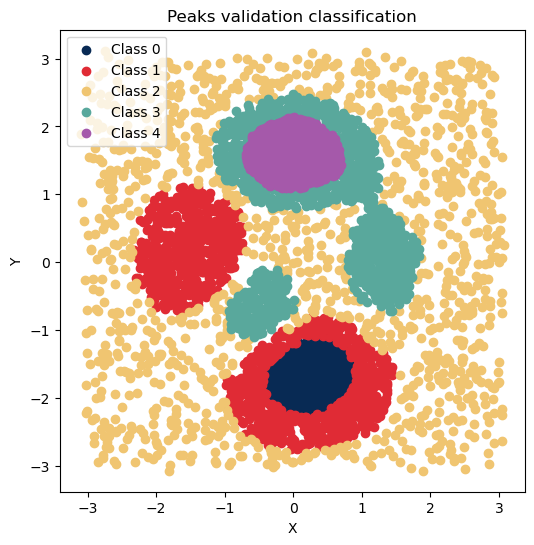

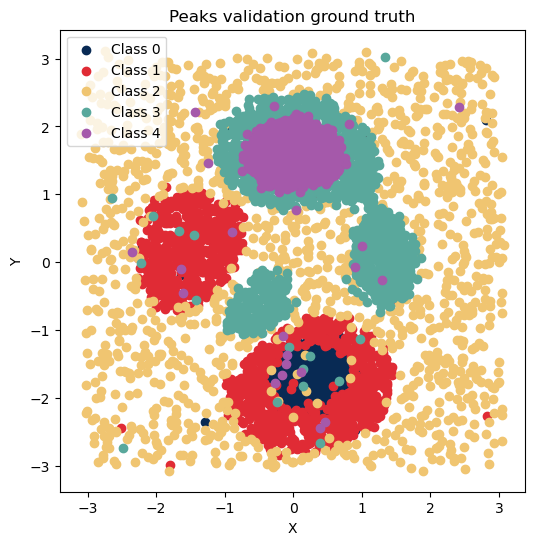

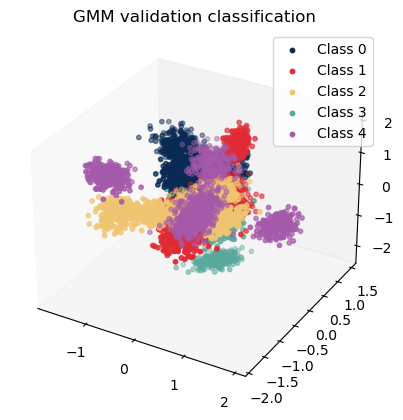

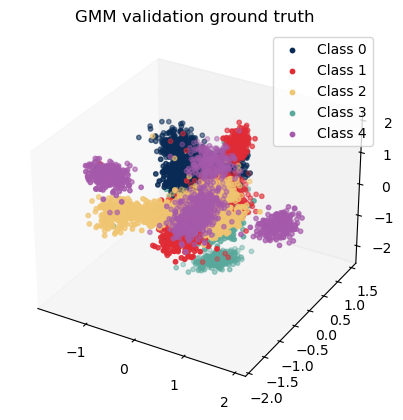

In [45]:
for (dataset_name, dataset) in datasets.items():
    network = network_comparisons_dict[dataset_name]\
        ["1 hidden layers vs. 2 hidden layers vs. 4 hidden layers"]\
        ["4 hidden layers"]["network"]
    
    _, _, X_val, Y_val = dataset
    
    classifications, _, _ = network.forward_pass(X_val, Y_val)
    
    plot_dataset(X_val, to_one_hot(to_classes(classifications), classifications.shape[0]), title=f"{dataset_name} validation classification")
    plot_dataset(X_val, Y_val, title=f"{dataset_name} validation ground truth")
    print()

### Conclusion for Part 3
From the visualization it's clear that the networks learned the data well.

Also it seems that at least some of the "inaccuracy" of the trained models, might stem from mislabeled truth (e.g. in Swissroll and Peaks.)